<a href="https://colab.research.google.com/github/Damisss/-monkey-species-classifier/blob/master/cnn_from_scratch_using_tf_keras_tuner_acc_73.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Data can be download on: https://www.kaggle.com/slothkong/10-monkey-species

In [0]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /opt/conda/lib/python3.7/site-packages (1.0.1)


In [0]:
import itertools
import os
import math
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np

from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, Input, BatchNormalization
from tensorflow import keras

List of lables for corresponding images

In [0]:
species = {0:'mantled_howler', 
           1:'patas_monkey', 
           2: 'bald_uakari', 
           3: 'japanese_macaque', 
           4: 'pygmy_marmoset', 
           5: 'white_headed_capuchin',
           6: 'silvery_marmoset',
           7: 'common_squirrel_monkey',
           8: 'black_headed_night_monkey' ,
           9: 'nilgiri_langur'
           }

def prepare_labels (dataset):
  label = []
  for key, specie in species.items():
    path = f'../input/10-monkey-species/{dataset}/n{key}'
    species_list_length = len(os.listdir(path))
    for j in range (1, species_list_length + 1):
      label.append(specie)
  return label

List of images path

In [0]:
def prepare_images_paths (dataset):
  images = []
  for i in range (0, 10):
    path = f'../input/10-monkey-species/{dataset}/n{i}'
    for image in os.listdir(path):
      images.append(f'{path}/{image}')
  return images

In [0]:
X_train = prepare_images_paths('training/training')
y_train = prepare_labels('training/training')
X_valid =  prepare_images_paths('validation/validation')
y_valid = prepare_labels('validation/validation')

In [0]:
# Let's display species and their number 
pd.Series(y_train).value_counts()

japanese_macaque             122
common_squirrel_monkey       114
white_headed_capuchin        113
patas_monkey                 111
bald_uakari                  110
silvery_marmoset             106
black_headed_night_monkey    106
nilgiri_langur               106
pygmy_marmoset               105
mantled_howler               105
dtype: int64

Transform every label in list into boolean array.

In [0]:
# Let's transform each element in labels into an array of boolean
def label_transformation (labels):
  return [label == pd.Series(labels).unique() for label in labels]

In [0]:
y_train = label_transformation(y_train)
y_valid = label_transformation(y_valid)

Parsing images, resize them and then return a tuple containing images and their corresponding labels. 

In [0]:
size = [224, 224]
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    
    image = tf.image.decode_jpeg(image_string, channels=3)

    image = tf.image.convert_image_dtype(image, tf.float32)

    resized_image = tf.image.resize(image, size=size)
    return resized_image, label

Image augmentations (i.e. numbers of images and their corresponding labels)

In [0]:
def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    
    image = tf.image.random_flip_left_right(image)
    
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

Create a mini batch that will be passed to the model at a time

In [0]:
class MiniBatch ():
  def __init__ (self, batch_size):
    self.batch_size = batch_size
  
  def training_batch (self, X, y):
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    dataset_shuffled = dataset.shuffle(buffer_size=len(X))
    dataset = dataset_shuffled.map(parse_function, num_parallel_calls=4)
    dataset = dataset.map(train_preprocess, num_parallel_calls=4).batch(self.batch_size)
    dataset = dataset.prefetch(1)

    return dataset
  
  def validation_batch (self, X, y):
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    dataset = dataset.map(parse_function,  num_parallel_calls=4).batch(self.batch_size)
    dataset = dataset.prefetch(1)
    return dataset

In [0]:
mini_batch = MiniBatch(32)
train_data = mini_batch.training_batch(X_train, y_train)
valid_data = mini_batch.validation_batch(X_valid, y_valid)

Lwt's build our model

In [0]:
def build_model (hp):
 
  i = Input(shape=[224, 224, 3])
  x = Conv2D(hp.Int(f'conv_1', min_value=64, max_value=128, step=32),
             kernel_size=hp.Choice('conv_1_kernel', values = [3,5, 7]),
             activation='relu',  padding='same')(i) #kernel_initializer='he_uniform',

  x = BatchNormalization()(x)

  x = Conv2D(hp.Int(f'conv_2', min_value=64, max_value=128, step=32),
             kernel_size=hp.Choice('conv_2_kernel', values = [3,5, 7]),
             activation='relu', padding='same')(x)

  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2, 2))(x)
  x = Dropout(0.3)(x)

  for layer in range(hp.Int('n_layers', 1, 6)):   
    x = Conv2D(hp.Int(f'firs_conv_{layer}_units', min_value=64, max_value=256, step=32),
               kernel_size=hp.Choice(f'firs_conv_{layer}_kernel', values = [3,5]),
               activation='relu', padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv2D(hp.Int(f'second_conv_{layer}_units', min_value=64, max_value=256, step=32),
               kernel_size=hp.Choice(f'second_conv_{layer}_kernel', values = [3,5]),
               activation='relu', padding='same')(x)

    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
  
  x=Flatten()(x)
  x = Dropout(0.3)(x)
  x=Dense(hp.Int(f'Dense_units', min_value=700, max_value=1024, step=100), activation='relu')(x)
  x = Dropout(0.4)(x)
  x=Dense(10, activation='softmax')(x)
  model = keras.Model(inputs=[i], outputs=[x])
  model.compile(optimizer= keras.optimizers.Adam(learning_rate=hp.Choice(f'lsr', values=[2.5e-04, 1.25e-04])), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Let's perform random search. It is like hypermeters tuning of the model. 

In [0]:
tuner_search = RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,
                          directory='output',
                          project_name="Monkey species2",
                          executions_per_trial=2,
                          )

In [0]:
tuner_search.search(x=train_data, validation_data=valid_data, epochs=50)

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 5.2317 - accuracy: 0.03 - ETA: 5s - loss: 4.8690 - accuracy: 0.06 - ETA: 8s - loss: 4.5490 - accuracy: 0.09 - ETA: 8s - loss: 4.5267 - accuracy: 0.10 - ETA: 8s - loss: 4.4537 - accuracy: 0.10 - ETA: 8s - loss: 4.4505 - accuracy: 0.10 - ETA: 8s - loss: 4.3418 - accuracy: 0.10 - ETA: 8s - loss: 4.2475 - accuracy: 0.10 - ETA: 8s - loss: 4.2035 - accuracy: 0.11 - ETA: 7s - loss: 4.1603 - accuracy: 0.12 - ETA: 7s - loss: 4.1394 - accuracy: 0.11 - ETA: 7s - loss: 4.1064 - accuracy: 0.11 - ETA: 6s - loss: 4.1090 - accuracy: 0.11 - ETA: 6s - loss: 4.0938 - accuracy: 0.11 - ETA: 6s - loss: 4.0594 - accuracy: 0.11 - ETA: 6s - loss: 3.9991 - accuracy: 0.12 - ETA: 5s - loss: 4.0136 - accuracy: 0.12 - ETA: 6s - loss: 3.9923 - accuracy: 0.12 - ETA: 5s - loss: 3.9452 - accuracy: 0.12 - ETA: 5s - loss: 3.9447 - accuracy: 0.12 - ETA: 5s - loss: 3.9716 - accuracy: 0.11 - ETA: 5s - loss: 3.9251 - accuracy: 0.12 - ETA: 5s - loss: 3.9162 -

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 2.3762 - accuracy: 0.31 - ETA: 9s - loss: 2.3187 - accuracy: 0.31 - ETA: 9s - loss: 2.2279 - accuracy: 0.32 - ETA: 9s - loss: 2.1530 - accuracy: 0.34 - ETA: 12s - loss: 2.1552 - accuracy: 0.337 - ETA: 12s - loss: 2.2279 - accuracy: 0.312 - ETA: 14s - loss: 2.2455 - accuracy: 0.308 - ETA: 13s - loss: 2.1916 - accuracy: 0.328 - ETA: 12s - loss: 2.1816 - accuracy: 0.329 - ETA: 12s - loss: 2.1719 - accuracy: 0.331 - ETA: 13s - loss: 2.1825 - accuracy: 0.326 - ETA: 13s - loss: 2.1666 - accuracy: 0.338 - ETA: 12s - loss: 2.1556 - accuracy: 0.346 - ETA: 12s - loss: 2.1659 - accuracy: 0.346 - ETA: 11s - loss: 2.1464 - accuracy: 0.347 - ETA: 10s - loss: 2.1367 - accuracy: 0.343 - ETA: 9s - loss: 2.1534 - accuracy: 0.340 - ETA: 9s - loss: 2.1697 - accuracy: 0.33 - ETA: 9s - loss: 2.1520 - accuracy: 0.33 - ETA: 8s - loss: 2.1750 - accuracy: 0.32 - ETA: 8s - loss: 2.1575 - accuracy: 0.32 - ETA: 7s - loss: 2.1612 - accuracy: 0.32 -

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 1.7351 - accuracy: 0.50 - ETA: 12s - loss: 1.8216 - accuracy: 0.390 - ETA: 13s - loss: 1.7380 - accuracy: 0.437 - ETA: 14s - loss: 1.8263 - accuracy: 0.398 - ETA: 13s - loss: 1.8254 - accuracy: 0.387 - ETA: 12s - loss: 1.7863 - accuracy: 0.395 - ETA: 11s - loss: 1.7646 - accuracy: 0.397 - ETA: 11s - loss: 1.7879 - accuracy: 0.398 - ETA: 12s - loss: 1.7722 - accuracy: 0.399 - ETA: 11s - loss: 1.7721 - accuracy: 0.396 - ETA: 12s - loss: 1.7640 - accuracy: 0.392 - ETA: 11s - loss: 1.7568 - accuracy: 0.398 - ETA: 10s - loss: 1.7800 - accuracy: 0.394 - ETA: 10s - loss: 1.8090 - accuracy: 0.379 - ETA: 10s - loss: 1.7812 - accuracy: 0.387 - ETA: 10s - loss: 1.7954 - accuracy: 0.386 - ETA: 9s - loss: 1.7931 - accuracy: 0.389 - ETA: 9s - loss: 1.8081 - accuracy: 0.38 - ETA: 8s - loss: 1.7921 - accuracy: 0.39 - ETA: 8s - loss: 1.7801 - accuracy: 0.39 - ETA: 7s - loss: 1.7439 - accuracy: 0.40 - ETA: 7s - loss: 1.7494 - accuracy:

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 1.7211 - accuracy: 0.43 - ETA: 16s - loss: 1.4140 - accuracy: 0.562 - ETA: 19s - loss: 1.4521 - accuracy: 0.500 - ETA: 16s - loss: 1.3026 - accuracy: 0.562 - ETA: 15s - loss: 1.3736 - accuracy: 0.550 - ETA: 15s - loss: 1.4075 - accuracy: 0.531 - ETA: 15s - loss: 1.4456 - accuracy: 0.517 - ETA: 14s - loss: 1.4501 - accuracy: 0.511 - ETA: 13s - loss: 1.4381 - accuracy: 0.506 - ETA: 12s - loss: 1.4319 - accuracy: 0.512 - ETA: 13s - loss: 1.3953 - accuracy: 0.525 - ETA: 12s - loss: 1.4014 - accuracy: 0.523 - ETA: 11s - loss: 1.3888 - accuracy: 0.521 - ETA: 11s - loss: 1.3867 - accuracy: 0.517 - ETA: 10s - loss: 1.3677 - accuracy: 0.525 - ETA: 10s - loss: 1.3787 - accuracy: 0.519 - ETA: 9s - loss: 1.3856 - accuracy: 0.514 - ETA: 9s - loss: 1.3885 - accuracy: 0.51 - ETA: 8s - loss: 1.3748 - accuracy: 0.51 - ETA: 7s - loss: 1.3775 - accuracy: 0.50 - ETA: 7s - loss: 1.3865 - accuracy: 0.50 - ETA: 6s - loss: 1.3886 - accuracy:

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 1.0837 - accuracy: 0.59 - ETA: 5s - loss: 1.0930 - accuracy: 0.54 - ETA: 9s - loss: 1.1234 - accuracy: 0.58 - ETA: 10s - loss: 1.0700 - accuracy: 0.609 - ETA: 9s - loss: 1.1181 - accuracy: 0.587 - ETA: 10s - loss: 1.1448 - accuracy: 0.562 - ETA: 10s - loss: 1.2115 - accuracy: 0.540 - ETA: 10s - loss: 1.2180 - accuracy: 0.535 - ETA: 10s - loss: 1.1915 - accuracy: 0.545 - ETA: 10s - loss: 1.1814 - accuracy: 0.546 - ETA: 10s - loss: 1.2129 - accuracy: 0.548 - ETA: 10s - loss: 1.2227 - accuracy: 0.552 - ETA: 9s - loss: 1.2202 - accuracy: 0.557 - ETA: 9s - loss: 1.2460 - accuracy: 0.55 - ETA: 9s - loss: 1.2315 - accuracy: 0.55 - ETA: 9s - loss: 1.2249 - accuracy: 0.55 - ETA: 9s - loss: 1.2255 - accuracy: 0.55 - ETA: 8s - loss: 1.2193 - accuracy: 0.55 - ETA: 8s - loss: 1.2098 - accuracy: 0.56 - ETA: 8s - loss: 1.2106 - accuracy: 0.56 - ETA: 7s - loss: 1.2098 - accuracy: 0.56 - ETA: 7s - loss: 1.2303 - accuracy: 0.55 - ETA: 

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 1.6319 - accuracy: 0.43 - ETA: 5s - loss: 1.3018 - accuracy: 0.54 - ETA: 13s - loss: 1.1879 - accuracy: 0.572 - ETA: 11s - loss: 1.1287 - accuracy: 0.601 - ETA: 12s - loss: 1.0893 - accuracy: 0.612 - ETA: 14s - loss: 1.0652 - accuracy: 0.630 - ETA: 14s - loss: 1.1500 - accuracy: 0.607 - ETA: 14s - loss: 1.1406 - accuracy: 0.605 - ETA: 14s - loss: 1.0914 - accuracy: 0.625 - ETA: 13s - loss: 1.0968 - accuracy: 0.631 - ETA: 12s - loss: 1.1189 - accuracy: 0.616 - ETA: 12s - loss: 1.1410 - accuracy: 0.606 - ETA: 11s - loss: 1.1328 - accuracy: 0.608 - ETA: 11s - loss: 1.1244 - accuracy: 0.607 - ETA: 11s - loss: 1.1148 - accuracy: 0.604 - ETA: 10s - loss: 1.1113 - accuracy: 0.601 - ETA: 9s - loss: 1.1187 - accuracy: 0.602 - ETA: 9s - loss: 1.1262 - accuracy: 0.60 - ETA: 9s - loss: 1.1089 - accuracy: 0.60 - ETA: 8s - loss: 1.0999 - accuracy: 0.60 - ETA: 8s - loss: 1.1070 - accuracy: 0.59 - ETA: 7s - loss: 1.1113 - accuracy: 0

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 1.0600 - accuracy: 0.68 - ETA: 6s - loss: 0.9332 - accuracy: 0.68 - ETA: 8s - loss: 1.0504 - accuracy: 0.64 - ETA: 8s - loss: 1.0714 - accuracy: 0.62 - ETA: 11s - loss: 1.0799 - accuracy: 0.631 - ETA: 12s - loss: 1.1206 - accuracy: 0.609 - ETA: 12s - loss: 1.0619 - accuracy: 0.616 - ETA: 13s - loss: 1.0428 - accuracy: 0.621 - ETA: 12s - loss: 1.0316 - accuracy: 0.625 - ETA: 11s - loss: 1.0221 - accuracy: 0.628 - ETA: 11s - loss: 1.0167 - accuracy: 0.639 - ETA: 11s - loss: 1.0296 - accuracy: 0.638 - ETA: 11s - loss: 1.0549 - accuracy: 0.627 - ETA: 11s - loss: 1.0629 - accuracy: 0.627 - ETA: 10s - loss: 1.0363 - accuracy: 0.637 - ETA: 10s - loss: 1.0307 - accuracy: 0.642 - ETA: 9s - loss: 1.0214 - accuracy: 0.645 - ETA: 9s - loss: 1.0099 - accuracy: 0.65 - ETA: 8s - loss: 1.0089 - accuracy: 0.65 - ETA: 8s - loss: 1.0010 - accuracy: 0.65 - ETA: 8s - loss: 1.0029 - accuracy: 0.65 - ETA: 7s - loss: 1.0023 - accuracy: 0.64 

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.78 - ETA: 7s - loss: 0.7469 - accuracy: 0.70 - ETA: 8s - loss: 0.8222 - accuracy: 0.67 - ETA: 8s - loss: 0.7880 - accuracy: 0.70 - ETA: 11s - loss: 0.7808 - accuracy: 0.693 - ETA: 13s - loss: 0.8429 - accuracy: 0.661 - ETA: 13s - loss: 0.8433 - accuracy: 0.665 - ETA: 13s - loss: 0.8275 - accuracy: 0.664 - ETA: 13s - loss: 0.8457 - accuracy: 0.659 - ETA: 12s - loss: 0.8883 - accuracy: 0.646 - ETA: 12s - loss: 0.9078 - accuracy: 0.644 - ETA: 12s - loss: 0.9070 - accuracy: 0.645 - ETA: 12s - loss: 0.9237 - accuracy: 0.641 - ETA: 12s - loss: 0.9229 - accuracy: 0.645 - ETA: 12s - loss: 0.9261 - accuracy: 0.645 - ETA: 11s - loss: 0.9219 - accuracy: 0.646 - ETA: 10s - loss: 0.9137 - accuracy: 0.648 - ETA: 9s - loss: 0.9060 - accuracy: 0.654 - ETA: 8s - loss: 0.9052 - accuracy: 0.65 - ETA: 8s - loss: 0.9003 - accuracy: 0.65 - ETA: 7s - loss: 0.9138 - accuracy: 0.65 - ETA: 7s - loss: 0.9329 - accuracy: 0.6

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.68 - ETA: 15s - loss: 0.7580 - accuracy: 0.687 - ETA: 14s - loss: 0.7523 - accuracy: 0.708 - ETA: 14s - loss: 0.7826 - accuracy: 0.687 - ETA: 14s - loss: 0.9128 - accuracy: 0.650 - ETA: 15s - loss: 0.9079 - accuracy: 0.645 - ETA: 14s - loss: 0.8976 - accuracy: 0.656 - ETA: 13s - loss: 0.9321 - accuracy: 0.652 - ETA: 13s - loss: 0.9099 - accuracy: 0.666 - ETA: 13s - loss: 0.9194 - accuracy: 0.659 - ETA: 12s - loss: 0.9269 - accuracy: 0.653 - ETA: 12s - loss: 0.9063 - accuracy: 0.653 - ETA: 12s - loss: 0.8894 - accuracy: 0.656 - ETA: 11s - loss: 0.8893 - accuracy: 0.658 - ETA: 11s - loss: 0.8938 - accuracy: 0.660 - ETA: 10s - loss: 0.8844 - accuracy: 0.664 - ETA: 10s - loss: 0.8831 - accuracy: 0.665 - ETA: 9s - loss: 0.8805 - accuracy: 0.668 - ETA: 9s - loss: 0.8791 - accuracy: 0.66 - ETA: 8s - loss: 0.8906 - accuracy: 0.66 - ETA: 8s - loss: 0.8788 - accuracy: 0.67 - ETA: 7s - loss: 0.8762 - accurac

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.71 - ETA: 9s - loss: 0.8031 - accuracy: 0.65 - ETA: 10s - loss: 0.8099 - accuracy: 0.677 - ETA: 11s - loss: 0.7898 - accuracy: 0.695 - ETA: 11s - loss: 0.7543 - accuracy: 0.712 - ETA: 10s - loss: 0.8047 - accuracy: 0.703 - ETA: 11s - loss: 0.8085 - accuracy: 0.709 - ETA: 12s - loss: 0.8020 - accuracy: 0.707 - ETA: 11s - loss: 0.8318 - accuracy: 0.694 - ETA: 11s - loss: 0.8202 - accuracy: 0.696 - ETA: 11s - loss: 0.8027 - accuracy: 0.707 - ETA: 11s - loss: 0.8383 - accuracy: 0.700 - ETA: 12s - loss: 0.8409 - accuracy: 0.697 - ETA: 11s - loss: 0.8336 - accuracy: 0.700 - ETA: 10s - loss: 0.8428 - accuracy: 0.691 - ETA: 10s - loss: 0.8452 - accuracy: 0.689 - ETA: 10s - loss: 0.8366 - accuracy: 0.693 - ETA: 9s - loss: 0.8328 - accuracy: 0.697 - ETA: 8s - loss: 0.8270 - accuracy: 0.70 - ETA: 8s - loss: 0.8117 - accuracy: 0.71 - ETA: 7s - loss: 0.7992 - accuracy: 0.71 - ETA: 7s - loss: 0.7887 - accuracy:

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 4.5775 - accuracy: 0.03 - ETA: 20s - loss: 4.5988 - accuracy: 0.031 - ETA: 18s - loss: 4.4499 - accuracy: 0.062 - ETA: 16s - loss: 4.3801 - accuracy: 0.070 - ETA: 16s - loss: 4.2018 - accuracy: 0.075 - ETA: 17s - loss: 3.9972 - accuracy: 0.072 - ETA: 17s - loss: 3.8656 - accuracy: 0.084 - ETA: 16s - loss: 3.9632 - accuracy: 0.074 - ETA: 15s - loss: 3.9419 - accuracy: 0.076 - ETA: 14s - loss: 3.9415 - accuracy: 0.071 - ETA: 13s - loss: 3.9032 - accuracy: 0.068 - ETA: 12s - loss: 3.8431 - accuracy: 0.070 - ETA: 13s - loss: 3.7767 - accuracy: 0.081 - ETA: 12s - loss: 3.7729 - accuracy: 0.082 - ETA: 12s - loss: 3.7897 - accuracy: 0.083 - ETA: 11s - loss: 3.7920 - accuracy: 0.087 - ETA: 11s - loss: 3.7494 - accuracy: 0.093 - ETA: 10s - loss: 3.7381 - accuracy: 0.090 - ETA: 9s - loss: 3.7160 - accuracy: 0.095 - ETA: 9s - loss: 3.6769 - accuracy: 0.10 - ETA: 8s - loss: 3.6780 - accuracy: 0.10 - ETA: 7s - loss: 3.6680 - accura

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 2.0437 - accuracy: 0.34 - ETA: 6s - loss: 2.2009 - accuracy: 0.31 - ETA: 13s - loss: 2.2912 - accuracy: 0.250 - ETA: 13s - loss: 2.2281 - accuracy: 0.257 - ETA: 13s - loss: 2.2406 - accuracy: 0.256 - ETA: 13s - loss: 2.2231 - accuracy: 0.265 - ETA: 12s - loss: 2.3190 - accuracy: 0.267 - ETA: 13s - loss: 2.2832 - accuracy: 0.277 - ETA: 12s - loss: 2.3273 - accuracy: 0.270 - ETA: 12s - loss: 2.3060 - accuracy: 0.281 - ETA: 14s - loss: 2.2719 - accuracy: 0.281 - ETA: 13s - loss: 2.2460 - accuracy: 0.289 - ETA: 13s - loss: 2.3010 - accuracy: 0.288 - ETA: 12s - loss: 2.3338 - accuracy: 0.281 - ETA: 11s - loss: 2.3695 - accuracy: 0.277 - ETA: 11s - loss: 2.3695 - accuracy: 0.277 - ETA: 11s - loss: 2.3689 - accuracy: 0.279 - ETA: 10s - loss: 2.3708 - accuracy: 0.279 - ETA: 10s - loss: 2.3604 - accuracy: 0.278 - ETA: 9s - loss: 2.3573 - accuracy: 0.279 - ETA: 8s - loss: 2.3540 - accuracy: 0.27 - ETA: 7s - loss: 2.3338 - accura

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 1.6259 - accuracy: 0.43 - ETA: 7s - loss: 1.7650 - accuracy: 0.35 - ETA: 13s - loss: 2.0257 - accuracy: 0.322 - ETA: 13s - loss: 1.9304 - accuracy: 0.359 - ETA: 13s - loss: 1.9402 - accuracy: 0.362 - ETA: 14s - loss: 1.8721 - accuracy: 0.395 - ETA: 16s - loss: 1.8742 - accuracy: 0.379 - ETA: 15s - loss: 1.8421 - accuracy: 0.378 - ETA: 14s - loss: 1.8371 - accuracy: 0.375 - ETA: 14s - loss: 1.8591 - accuracy: 0.368 - ETA: 13s - loss: 1.8572 - accuracy: 0.372 - ETA: 12s - loss: 1.8306 - accuracy: 0.382 - ETA: 12s - loss: 1.8098 - accuracy: 0.391 - ETA: 11s - loss: 1.8023 - accuracy: 0.397 - ETA: 10s - loss: 1.7845 - accuracy: 0.395 - ETA: 10s - loss: 1.7756 - accuracy: 0.398 - ETA: 9s - loss: 1.7632 - accuracy: 0.404 - ETA: 9s - loss: 1.7758 - accuracy: 0.39 - ETA: 8s - loss: 1.7590 - accuracy: 0.40 - ETA: 8s - loss: 1.7472 - accuracy: 0.40 - ETA: 7s - loss: 1.7573 - accuracy: 0.40 - ETA: 7s - loss: 1.7542 - accuracy: 0

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 1.4001 - accuracy: 0.56 - ETA: 8s - loss: 1.4786 - accuracy: 0.51 - ETA: 9s - loss: 1.5202 - accuracy: 0.45 - ETA: 11s - loss: 1.4453 - accuracy: 0.492 - ETA: 12s - loss: 1.4919 - accuracy: 0.481 - ETA: 13s - loss: 1.5133 - accuracy: 0.463 - ETA: 12s - loss: 1.5362 - accuracy: 0.464 - ETA: 11s - loss: 1.5002 - accuracy: 0.484 - ETA: 11s - loss: 1.5408 - accuracy: 0.458 - ETA: 10s - loss: 1.5349 - accuracy: 0.465 - ETA: 11s - loss: 1.4936 - accuracy: 0.483 - ETA: 10s - loss: 1.4838 - accuracy: 0.481 - ETA: 10s - loss: 1.4669 - accuracy: 0.490 - ETA: 10s - loss: 1.4657 - accuracy: 0.495 - ETA: 10s - loss: 1.4661 - accuracy: 0.493 - ETA: 10s - loss: 1.4655 - accuracy: 0.492 - ETA: 9s - loss: 1.4782 - accuracy: 0.487 - ETA: 9s - loss: 1.4702 - accuracy: 0.48 - ETA: 8s - loss: 1.4595 - accuracy: 0.49 - ETA: 8s - loss: 1.4648 - accuracy: 0.49 - ETA: 7s - loss: 1.4717 - accuracy: 0.49 - ETA: 7s - loss: 1.4654 - accuracy: 0.4

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 1.3389 - accuracy: 0.62 - ETA: 8s - loss: 1.5029 - accuracy: 0.48 - ETA: 10s - loss: 1.3668 - accuracy: 0.531 - ETA: 13s - loss: 1.3202 - accuracy: 0.546 - ETA: 12s - loss: 1.2419 - accuracy: 0.575 - ETA: 12s - loss: 1.1924 - accuracy: 0.588 - ETA: 13s - loss: 1.2286 - accuracy: 0.562 - ETA: 14s - loss: 1.2756 - accuracy: 0.550 - ETA: 15s - loss: 1.3001 - accuracy: 0.538 - ETA: 14s - loss: 1.3348 - accuracy: 0.518 - ETA: 13s - loss: 1.3335 - accuracy: 0.528 - ETA: 12s - loss: 1.3668 - accuracy: 0.528 - ETA: 12s - loss: 1.3928 - accuracy: 0.521 - ETA: 11s - loss: 1.3944 - accuracy: 0.515 - ETA: 11s - loss: 1.3941 - accuracy: 0.510 - ETA: 10s - loss: 1.3836 - accuracy: 0.511 - ETA: 10s - loss: 1.3618 - accuracy: 0.522 - ETA: 9s - loss: 1.3660 - accuracy: 0.524 - ETA: 9s - loss: 1.3461 - accuracy: 0.52 - ETA: 8s - loss: 1.3423 - accuracy: 0.53 - ETA: 8s - loss: 1.3363 - accuracy: 0.53 - ETA: 7s - loss: 1.3295 - accuracy:

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 1.0156 - accuracy: 0.65 - ETA: 5s - loss: 1.1774 - accuracy: 0.57 - ETA: 8s - loss: 1.1305 - accuracy: 0.60 - ETA: 13s - loss: 1.1223 - accuracy: 0.609 - ETA: 12s - loss: 1.1374 - accuracy: 0.593 - ETA: 13s - loss: 1.1141 - accuracy: 0.609 - ETA: 12s - loss: 1.1791 - accuracy: 0.593 - ETA: 12s - loss: 1.1698 - accuracy: 0.597 - ETA: 11s - loss: 1.1030 - accuracy: 0.628 - ETA: 10s - loss: 1.0838 - accuracy: 0.640 - ETA: 10s - loss: 1.0703 - accuracy: 0.639 - ETA: 10s - loss: 1.0681 - accuracy: 0.638 - ETA: 10s - loss: 1.0545 - accuracy: 0.641 - ETA: 10s - loss: 1.0482 - accuracy: 0.645 - ETA: 9s - loss: 1.0455 - accuracy: 0.643 - ETA: 9s - loss: 1.0849 - accuracy: 0.62 - ETA: 8s - loss: 1.0962 - accuracy: 0.63 - ETA: 7s - loss: 1.1024 - accuracy: 0.62 - ETA: 7s - loss: 1.1212 - accuracy: 0.61 - ETA: 7s - loss: 1.1283 - accuracy: 0.61 - ETA: 7s - loss: 1.1588 - accuracy: 0.60 - ETA: 6s - loss: 1.1480 - accuracy: 0.60 - 

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 1.1372 - accuracy: 0.56 - ETA: 9s - loss: 0.9799 - accuracy: 0.65 - ETA: 17s - loss: 1.0272 - accuracy: 0.614 - ETA: 15s - loss: 0.9880 - accuracy: 0.625 - ETA: 13s - loss: 0.9556 - accuracy: 0.643 - ETA: 13s - loss: 0.9648 - accuracy: 0.640 - ETA: 13s - loss: 0.9731 - accuracy: 0.629 - ETA: 13s - loss: 0.9622 - accuracy: 0.640 - ETA: 12s - loss: 0.9633 - accuracy: 0.638 - ETA: 11s - loss: 0.9733 - accuracy: 0.637 - ETA: 11s - loss: 1.0072 - accuracy: 0.625 - ETA: 11s - loss: 1.0463 - accuracy: 0.627 - ETA: 10s - loss: 1.0810 - accuracy: 0.622 - ETA: 10s - loss: 1.0818 - accuracy: 0.616 - ETA: 9s - loss: 1.0825 - accuracy: 0.618 - ETA: 9s - loss: 1.0670 - accuracy: 0.63 - ETA: 9s - loss: 1.0755 - accuracy: 0.62 - ETA: 8s - loss: 1.0764 - accuracy: 0.62 - ETA: 8s - loss: 1.0969 - accuracy: 0.61 - ETA: 7s - loss: 1.0899 - accuracy: 0.61 - ETA: 7s - loss: 1.0777 - accuracy: 0.62 - ETA: 6s - loss: 1.0731 - accuracy: 0.62 

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 1.2201 - accuracy: 0.59 - ETA: 14s - loss: 1.1145 - accuracy: 0.656 - ETA: 13s - loss: 1.0462 - accuracy: 0.656 - ETA: 12s - loss: 1.0145 - accuracy: 0.640 - ETA: 11s - loss: 1.0040 - accuracy: 0.650 - ETA: 10s - loss: 0.9978 - accuracy: 0.656 - ETA: 11s - loss: 1.0204 - accuracy: 0.629 - ETA: 11s - loss: 0.9926 - accuracy: 0.640 - ETA: 11s - loss: 0.9714 - accuracy: 0.638 - ETA: 10s - loss: 0.9677 - accuracy: 0.653 - ETA: 10s - loss: 1.0085 - accuracy: 0.642 - ETA: 9s - loss: 1.0155 - accuracy: 0.643 - ETA: 10s - loss: 1.0122 - accuracy: 0.646 - ETA: 10s - loss: 0.9739 - accuracy: 0.656 - ETA: 9s - loss: 0.9942 - accuracy: 0.645 - ETA: 9s - loss: 1.0225 - accuracy: 0.63 - ETA: 8s - loss: 1.0192 - accuracy: 0.63 - ETA: 8s - loss: 1.0480 - accuracy: 0.62 - ETA: 8s - loss: 1.0174 - accuracy: 0.64 - ETA: 7s - loss: 1.0236 - accuracy: 0.63 - ETA: 7s - loss: 1.0096 - accuracy: 0.64 - ETA: 6s - loss: 1.0097 - accuracy: 0.65

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.87 - ETA: 7s - loss: 0.9007 - accuracy: 0.71 - ETA: 13s - loss: 0.8827 - accuracy: 0.708 - ETA: 14s - loss: 0.8736 - accuracy: 0.703 - ETA: 14s - loss: 0.8542 - accuracy: 0.700 - ETA: 13s - loss: 0.8902 - accuracy: 0.687 - ETA: 13s - loss: 0.8657 - accuracy: 0.696 - ETA: 13s - loss: 0.8310 - accuracy: 0.707 - ETA: 13s - loss: 0.8293 - accuracy: 0.691 - ETA: 12s - loss: 0.8249 - accuracy: 0.696 - ETA: 13s - loss: 0.8426 - accuracy: 0.690 - ETA: 12s - loss: 0.8667 - accuracy: 0.684 - ETA: 11s - loss: 0.8675 - accuracy: 0.682 - ETA: 10s - loss: 0.9138 - accuracy: 0.671 - ETA: 10s - loss: 0.9043 - accuracy: 0.672 - ETA: 10s - loss: 0.9099 - accuracy: 0.671 - ETA: 10s - loss: 0.8982 - accuracy: 0.674 - ETA: 9s - loss: 0.9006 - accuracy: 0.673 - ETA: 8s - loss: 0.8940 - accuracy: 0.67 - ETA: 8s - loss: 0.8915 - accuracy: 0.67 - ETA: 7s - loss: 0.8915 - accuracy: 0.67 - ETA: 7s - loss: 0.8883 - accuracy:

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.8689 - accuracy: 0.68 - ETA: 13s - loss: 0.7719 - accuracy: 0.734 - ETA: 12s - loss: 0.7729 - accuracy: 0.729 - ETA: 12s - loss: 0.7412 - accuracy: 0.726 - ETA: 14s - loss: 0.7057 - accuracy: 0.750 - ETA: 16s - loss: 0.7423 - accuracy: 0.739 - ETA: 15s - loss: 0.7122 - accuracy: 0.741 - ETA: 14s - loss: 0.7660 - accuracy: 0.722 - ETA: 14s - loss: 0.7570 - accuracy: 0.725 - ETA: 13s - loss: 0.7339 - accuracy: 0.734 - ETA: 13s - loss: 0.7300 - accuracy: 0.738 - ETA: 13s - loss: 0.7479 - accuracy: 0.731 - ETA: 12s - loss: 0.7292 - accuracy: 0.738 - ETA: 11s - loss: 0.7247 - accuracy: 0.741 - ETA: 11s - loss: 0.7477 - accuracy: 0.731 - ETA: 10s - loss: 0.7471 - accuracy: 0.732 - ETA: 10s - loss: 0.7546 - accuracy: 0.731 - ETA: 9s - loss: 0.7504 - accuracy: 0.730 - ETA: 8s - loss: 0.7612 - accuracy: 0.72 - ETA: 8s - loss: 0.7567 - accuracy: 0.72 - ETA: 7s - loss: 0.7832 - accuracy: 0.71 - ETA: 6s - loss: 0.7834 - accurac

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 4.4933 - accuracy: 0.09 - ETA: 5s - loss: 4.6903 - accuracy: 0.10 - ETA: 9s - loss: 4.7104 - accuracy: 0.09 - ETA: 9s - loss: 4.4547 - accuracy: 0.14 - ETA: 10s - loss: 4.4151 - accuracy: 0.137 - ETA: 10s - loss: 4.3208 - accuracy: 0.135 - ETA: 9s - loss: 4.4153 - accuracy: 0.133 - ETA: 11s - loss: 4.4044 - accuracy: 0.128 - ETA: 10s - loss: 4.4338 - accuracy: 0.125 - ETA: 10s - loss: 4.4598 - accuracy: 0.118 - ETA: 9s - loss: 4.4396 - accuracy: 0.110 - ETA: 9s - loss: 4.3824 - accuracy: 0.12 - ETA: 9s - loss: 4.3197 - accuracy: 0.12 - ETA: 10s - loss: 4.2431 - accuracy: 0.125 - ETA: 10s - loss: 4.2630 - accuracy: 0.120 - ETA: 10s - loss: 4.1939 - accuracy: 0.127 - ETA: 9s - loss: 4.1673 - accuracy: 0.134 - ETA: 9s - loss: 4.1497 - accuracy: 0.13 - ETA: 8s - loss: 4.1312 - accuracy: 0.13 - ETA: 7s - loss: 4.1184 - accuracy: 0.13 - ETA: 7s - loss: 4.0843 - accuracy: 0.13 - ETA: 7s - loss: 4.0746 - accuracy: 0.13 - ETA: 

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 1.5770 - accuracy: 0.40 - ETA: 7s - loss: 1.7691 - accuracy: 0.37 - ETA: 16s - loss: 1.7592 - accuracy: 0.354 - ETA: 20s - loss: 1.8075 - accuracy: 0.375 - ETA: 18s - loss: 1.7399 - accuracy: 0.412 - ETA: 17s - loss: 1.7434 - accuracy: 0.411 - ETA: 17s - loss: 1.7789 - accuracy: 0.415 - ETA: 16s - loss: 1.7320 - accuracy: 0.441 - ETA: 15s - loss: 1.7177 - accuracy: 0.451 - ETA: 14s - loss: 1.7236 - accuracy: 0.443 - ETA: 13s - loss: 1.7294 - accuracy: 0.437 - ETA: 13s - loss: 1.7194 - accuracy: 0.447 - ETA: 13s - loss: 1.7001 - accuracy: 0.454 - ETA: 12s - loss: 1.7063 - accuracy: 0.457 - ETA: 11s - loss: 1.7262 - accuracy: 0.452 - ETA: 11s - loss: 1.7340 - accuracy: 0.447 - ETA: 10s - loss: 1.7429 - accuracy: 0.441 - ETA: 10s - loss: 1.7375 - accuracy: 0.441 - ETA: 10s - loss: 1.7076 - accuracy: 0.449 - ETA: 9s - loss: 1.7595 - accuracy: 0.443 - ETA: 8s - loss: 1.7461 - accuracy: 0.44 - ETA: 8s - loss: 1.7240 - accura

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 1.5147 - accuracy: 0.50 - ETA: 12s - loss: 1.3058 - accuracy: 0.531 - ETA: 19s - loss: 1.3744 - accuracy: 0.489 - ETA: 19s - loss: 1.3539 - accuracy: 0.492 - ETA: 17s - loss: 1.3231 - accuracy: 0.512 - ETA: 15s - loss: 1.3085 - accuracy: 0.536 - ETA: 14s - loss: 1.3455 - accuracy: 0.544 - ETA: 13s - loss: 1.3212 - accuracy: 0.550 - ETA: 13s - loss: 1.3294 - accuracy: 0.559 - ETA: 12s - loss: 1.2829 - accuracy: 0.568 - ETA: 13s - loss: 1.2889 - accuracy: 0.565 - ETA: 12s - loss: 1.2808 - accuracy: 0.570 - ETA: 12s - loss: 1.2543 - accuracy: 0.581 - ETA: 12s - loss: 1.2468 - accuracy: 0.587 - ETA: 11s - loss: 1.2503 - accuracy: 0.583 - ETA: 11s - loss: 1.2487 - accuracy: 0.585 - ETA: 10s - loss: 1.2430 - accuracy: 0.588 - ETA: 9s - loss: 1.2649 - accuracy: 0.579 - ETA: 9s - loss: 1.2723 - accuracy: 0.57 - ETA: 8s - loss: 1.2684 - accuracy: 0.58 - ETA: 8s - loss: 1.2772 - accuracy: 0.57 - ETA: 7s - loss: 1.2896 - accurac

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 0.9683 - accuracy: 0.68 - ETA: 7s - loss: 1.0238 - accuracy: 0.68 - ETA: 8s - loss: 1.0522 - accuracy: 0.65 - ETA: 8s - loss: 1.0120 - accuracy: 0.64 - ETA: 11s - loss: 1.0280 - accuracy: 0.637 - ETA: 11s - loss: 0.9829 - accuracy: 0.651 - ETA: 12s - loss: 0.9817 - accuracy: 0.656 - ETA: 12s - loss: 0.9737 - accuracy: 0.652 - ETA: 12s - loss: 0.9854 - accuracy: 0.645 - ETA: 13s - loss: 1.0088 - accuracy: 0.637 - ETA: 12s - loss: 1.0369 - accuracy: 0.636 - ETA: 11s - loss: 1.0302 - accuracy: 0.640 - ETA: 11s - loss: 1.0421 - accuracy: 0.639 - ETA: 10s - loss: 1.0608 - accuracy: 0.636 - ETA: 10s - loss: 1.0308 - accuracy: 0.645 - ETA: 10s - loss: 1.0436 - accuracy: 0.638 - ETA: 9s - loss: 1.0303 - accuracy: 0.639 - ETA: 8s - loss: 1.0228 - accuracy: 0.63 - ETA: 8s - loss: 1.0068 - accuracy: 0.64 - ETA: 7s - loss: 1.0125 - accuracy: 0.64 - ETA: 7s - loss: 1.0124 - accuracy: 0.63 - ETA: 6s - loss: 1.0038 - accuracy: 0.64 

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.81 - ETA: 12s - loss: 0.6415 - accuracy: 0.796 - ETA: 14s - loss: 0.9559 - accuracy: 0.708 - ETA: 12s - loss: 0.8994 - accuracy: 0.710 - ETA: 13s - loss: 0.9008 - accuracy: 0.706 - ETA: 14s - loss: 0.9180 - accuracy: 0.703 - ETA: 14s - loss: 0.8912 - accuracy: 0.714 - ETA: 13s - loss: 0.9061 - accuracy: 0.710 - ETA: 13s - loss: 0.9150 - accuracy: 0.704 - ETA: 12s - loss: 0.8961 - accuracy: 0.712 - ETA: 12s - loss: 0.8755 - accuracy: 0.718 - ETA: 11s - loss: 0.8631 - accuracy: 0.718 - ETA: 11s - loss: 0.8515 - accuracy: 0.718 - ETA: 10s - loss: 0.8618 - accuracy: 0.714 - ETA: 10s - loss: 0.8396 - accuracy: 0.714 - ETA: 9s - loss: 0.8373 - accuracy: 0.714 - ETA: 9s - loss: 0.8369 - accuracy: 0.71 - ETA: 8s - loss: 0.8359 - accuracy: 0.71 - ETA: 8s - loss: 0.8295 - accuracy: 0.71 - ETA: 7s - loss: 0.8092 - accuracy: 0.72 - ETA: 7s - loss: 0.7952 - accuracy: 0.72 - ETA: 7s - loss: 0.7960 - accuracy: 0

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.81 - ETA: 14s - loss: 0.4756 - accuracy: 0.843 - ETA: 13s - loss: 0.4322 - accuracy: 0.864 - ETA: 12s - loss: 0.5109 - accuracy: 0.835 - ETA: 11s - loss: 0.5294 - accuracy: 0.825 - ETA: 10s - loss: 0.5301 - accuracy: 0.828 - ETA: 11s - loss: 0.5669 - accuracy: 0.817 - ETA: 11s - loss: 0.5604 - accuracy: 0.812 - ETA: 11s - loss: 0.5621 - accuracy: 0.812 - ETA: 13s - loss: 0.5617 - accuracy: 0.809 - ETA: 12s - loss: 0.5562 - accuracy: 0.806 - ETA: 12s - loss: 0.5756 - accuracy: 0.804 - ETA: 11s - loss: 0.6018 - accuracy: 0.793 - ETA: 11s - loss: 0.6092 - accuracy: 0.794 - ETA: 11s - loss: 0.6239 - accuracy: 0.795 - ETA: 10s - loss: 0.6195 - accuracy: 0.793 - ETA: 9s - loss: 0.6383 - accuracy: 0.783 - ETA: 9s - loss: 0.6434 - accuracy: 0.78 - ETA: 8s - loss: 0.6355 - accuracy: 0.78 - ETA: 8s - loss: 0.6422 - accuracy: 0.78 - ETA: 7s - loss: 0.6357 - accuracy: 0.77 - ETA: 7s - loss: 0.6359 - accuracy:

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.81 - ETA: 8s - loss: 0.4487 - accuracy: 0.84 - ETA: 10s - loss: 0.3946 - accuracy: 0.854 - ETA: 17s - loss: 0.3834 - accuracy: 0.859 - ETA: 15s - loss: 0.3807 - accuracy: 0.856 - ETA: 15s - loss: 0.3648 - accuracy: 0.864 - ETA: 18s - loss: 0.4165 - accuracy: 0.857 - ETA: 17s - loss: 0.4155 - accuracy: 0.863 - ETA: 17s - loss: 0.4238 - accuracy: 0.861 - ETA: 16s - loss: 0.4283 - accuracy: 0.865 - ETA: 15s - loss: 0.4286 - accuracy: 0.860 - ETA: 14s - loss: 0.4510 - accuracy: 0.864 - ETA: 13s - loss: 0.4506 - accuracy: 0.860 - ETA: 12s - loss: 0.4507 - accuracy: 0.859 - ETA: 12s - loss: 0.4794 - accuracy: 0.852 - ETA: 11s - loss: 0.4681 - accuracy: 0.851 - ETA: 10s - loss: 0.4624 - accuracy: 0.852 - ETA: 9s - loss: 0.4544 - accuracy: 0.855 - ETA: 9s - loss: 0.4567 - accuracy: 0.85 - ETA: 8s - loss: 0.4554 - accuracy: 0.85 - ETA: 7s - loss: 0.4537 - accuracy: 0.85 - ETA: 7s - loss: 0.4524 - accuracy:

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.84 - ETA: 6s - loss: 0.3569 - accuracy: 0.87 - ETA: 7s - loss: 0.3563 - accuracy: 0.87 - ETA: 12s - loss: 0.4055 - accuracy: 0.851 - ETA: 16s - loss: 0.3766 - accuracy: 0.868 - ETA: 15s - loss: 0.3575 - accuracy: 0.869 - ETA: 14s - loss: 0.3671 - accuracy: 0.870 - ETA: 14s - loss: 0.4066 - accuracy: 0.851 - ETA: 13s - loss: 0.4075 - accuracy: 0.857 - ETA: 13s - loss: 0.3869 - accuracy: 0.865 - ETA: 12s - loss: 0.3875 - accuracy: 0.866 - ETA: 12s - loss: 0.3823 - accuracy: 0.869 - ETA: 11s - loss: 0.3674 - accuracy: 0.875 - ETA: 12s - loss: 0.3582 - accuracy: 0.881 - ETA: 11s - loss: 0.3767 - accuracy: 0.877 - ETA: 10s - loss: 0.3748 - accuracy: 0.875 - ETA: 10s - loss: 0.3862 - accuracy: 0.873 - ETA: 9s - loss: 0.3815 - accuracy: 0.875 - ETA: 8s - loss: 0.3868 - accuracy: 0.87 - ETA: 8s - loss: 0.3820 - accuracy: 0.87 - ETA: 8s - loss: 0.3848 - accuracy: 0.87 - ETA: 7s - loss: 0.3898 - accuracy: 0

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.81 - ETA: 5s - loss: 0.4105 - accuracy: 0.87 - ETA: 6s - loss: 0.3219 - accuracy: 0.90 - ETA: 8s - loss: 0.3635 - accuracy: 0.89 - ETA: 9s - loss: 0.3627 - accuracy: 0.90 - ETA: 9s - loss: 0.3579 - accuracy: 0.90 - ETA: 10s - loss: 0.3682 - accuracy: 0.888 - ETA: 11s - loss: 0.3870 - accuracy: 0.875 - ETA: 12s - loss: 0.3651 - accuracy: 0.878 - ETA: 11s - loss: 0.3723 - accuracy: 0.875 - ETA: 11s - loss: 0.3570 - accuracy: 0.877 - ETA: 10s - loss: 0.3782 - accuracy: 0.864 - ETA: 9s - loss: 0.3786 - accuracy: 0.865 - ETA: 9s - loss: 0.3687 - accuracy: 0.86 - ETA: 9s - loss: 0.3553 - accuracy: 0.87 - ETA: 8s - loss: 0.3582 - accuracy: 0.86 - ETA: 7s - loss: 0.3484 - accuracy: 0.87 - ETA: 7s - loss: 0.3476 - accuracy: 0.87 - ETA: 7s - loss: 0.3516 - accuracy: 0.87 - ETA: 7s - loss: 0.3482 - accuracy: 0.87 - ETA: 6s - loss: 0.3494 - accuracy: 0.87 - ETA: 6s - loss: 0.3480 - accuracy: 0.87 - ETA: 5s - 

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 1.00 - ETA: 13s - loss: 0.1754 - accuracy: 0.937 - ETA: 18s - loss: 0.2549 - accuracy: 0.916 - ETA: 43s - loss: 0.2372 - accuracy: 0.914 - ETA: 38s - loss: 0.2203 - accuracy: 0.931 - ETA: 36s - loss: 0.2416 - accuracy: 0.921 - ETA: 36s - loss: 0.2865 - accuracy: 0.897 - ETA: 32s - loss: 0.3122 - accuracy: 0.894 - ETA: 29s - loss: 0.3190 - accuracy: 0.895 - ETA: 27s - loss: 0.3100 - accuracy: 0.896 - ETA: 24s - loss: 0.2955 - accuracy: 0.900 - ETA: 23s - loss: 0.2893 - accuracy: 0.906 - ETA: 21s - loss: 0.2893 - accuracy: 0.906 - ETA: 19s - loss: 0.2826 - accuracy: 0.908 - ETA: 18s - loss: 0.2815 - accuracy: 0.906 - ETA: 16s - loss: 0.2736 - accuracy: 0.912 - ETA: 15s - loss: 0.2738 - accuracy: 0.909 - ETA: 14s - loss: 0.2713 - accuracy: 0.909 - ETA: 13s - loss: 0.2649 - accuracy: 0.909 - ETA: 12s - loss: 0.2663 - accuracy: 0.906 - ETA: 11s - loss: 0.2749 - accuracy: 0.904 - ETA: 10s - loss: 0.2713 -

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 6.1827 - accuracy: 0.03 - ETA: 18s - loss: 4.9247 - accuracy: 0.140 - ETA: 19s - loss: 5.0060 - accuracy: 0.114 - ETA: 21s - loss: 4.9544 - accuracy: 0.109 - ETA: 20s - loss: 4.8453 - accuracy: 0.125 - ETA: 17s - loss: 4.7097 - accuracy: 0.114 - ETA: 18s - loss: 4.6255 - accuracy: 0.111 - ETA: 18s - loss: 4.4986 - accuracy: 0.113 - ETA: 17s - loss: 4.4732 - accuracy: 0.118 - ETA: 17s - loss: 4.4859 - accuracy: 0.112 - ETA: 15s - loss: 4.6294 - accuracy: 0.108 - ETA: 14s - loss: 4.5987 - accuracy: 0.109 - ETA: 13s - loss: 4.5809 - accuracy: 0.110 - ETA: 13s - loss: 4.5974 - accuracy: 0.109 - ETA: 12s - loss: 4.5919 - accuracy: 0.108 - ETA: 12s - loss: 4.5072 - accuracy: 0.115 - ETA: 11s - loss: 4.4558 - accuracy: 0.119 - ETA: 10s - loss: 4.4325 - accuracy: 0.119 - ETA: 9s - loss: 4.4015 - accuracy: 0.125 - ETA: 8s - loss: 4.3472 - accuracy: 0.12 - ETA: 8s - loss: 4.3358 - accuracy: 0.12 - ETA: 7s - loss: 4.2938 - accura

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 2.1631 - accuracy: 0.34 - ETA: 22s - loss: 1.8726 - accuracy: 0.421 - ETA: 20s - loss: 1.6121 - accuracy: 0.479 - ETA: 20s - loss: 1.6506 - accuracy: 0.453 - ETA: 19s - loss: 1.6202 - accuracy: 0.475 - ETA: 17s - loss: 1.5912 - accuracy: 0.489 - ETA: 18s - loss: 1.5966 - accuracy: 0.491 - ETA: 17s - loss: 1.6424 - accuracy: 0.472 - ETA: 16s - loss: 1.6189 - accuracy: 0.479 - ETA: 15s - loss: 1.5961 - accuracy: 0.478 - ETA: 15s - loss: 1.6186 - accuracy: 0.477 - ETA: 14s - loss: 1.6014 - accuracy: 0.484 - ETA: 13s - loss: 1.6152 - accuracy: 0.483 - ETA: 14s - loss: 1.5979 - accuracy: 0.484 - ETA: 13s - loss: 1.5903 - accuracy: 0.487 - ETA: 11s - loss: 1.6066 - accuracy: 0.476 - ETA: 11s - loss: 1.6140 - accuracy: 0.470 - ETA: 10s - loss: 1.5937 - accuracy: 0.477 - ETA: 9s - loss: 1.5947 - accuracy: 0.478 - ETA: 9s - loss: 1.5896 - accuracy: 0.47 - ETA: 8s - loss: 1.5801 - accuracy: 0.48 - ETA: 7s - loss: 1.5818 - accura

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 1.2749 - accuracy: 0.46 - ETA: 7s - loss: 1.1197 - accuracy: 0.51 - ETA: 15s - loss: 1.1576 - accuracy: 0.510 - ETA: 15s - loss: 1.1965 - accuracy: 0.515 - ETA: 13s - loss: 1.1847 - accuracy: 0.518 - ETA: 14s - loss: 1.2313 - accuracy: 0.520 - ETA: 17s - loss: 1.3103 - accuracy: 0.486 - ETA: 15s - loss: 1.2836 - accuracy: 0.511 - ETA: 14s - loss: 1.2531 - accuracy: 0.517 - ETA: 14s - loss: 1.2981 - accuracy: 0.521 - ETA: 13s - loss: 1.2981 - accuracy: 0.525 - ETA: 12s - loss: 1.2955 - accuracy: 0.526 - ETA: 11s - loss: 1.2676 - accuracy: 0.536 - ETA: 11s - loss: 1.2828 - accuracy: 0.537 - ETA: 10s - loss: 1.3071 - accuracy: 0.535 - ETA: 10s - loss: 1.2943 - accuracy: 0.537 - ETA: 9s - loss: 1.3198 - accuracy: 0.527 - ETA: 9s - loss: 1.3249 - accuracy: 0.52 - ETA: 8s - loss: 1.3088 - accuracy: 0.53 - ETA: 8s - loss: 1.3127 - accuracy: 0.52 - ETA: 7s - loss: 1.3147 - accuracy: 0.53 - ETA: 6s - loss: 1.2997 - accuracy: 0

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 1.1162 - accuracy: 0.43 - ETA: 12s - loss: 1.4188 - accuracy: 0.406 - ETA: 11s - loss: 1.3236 - accuracy: 0.489 - ETA: 14s - loss: 1.2492 - accuracy: 0.515 - ETA: 14s - loss: 1.2069 - accuracy: 0.537 - ETA: 14s - loss: 1.1832 - accuracy: 0.572 - ETA: 14s - loss: 1.1588 - accuracy: 0.562 - ETA: 13s - loss: 1.1367 - accuracy: 0.578 - ETA: 13s - loss: 1.1076 - accuracy: 0.583 - ETA: 12s - loss: 1.1431 - accuracy: 0.581 - ETA: 12s - loss: 1.1168 - accuracy: 0.593 - ETA: 11s - loss: 1.0965 - accuracy: 0.601 - ETA: 11s - loss: 1.0740 - accuracy: 0.613 - ETA: 10s - loss: 1.0530 - accuracy: 0.620 - ETA: 9s - loss: 1.0481 - accuracy: 0.622 - ETA: 9s - loss: 1.0289 - accuracy: 0.62 - ETA: 9s - loss: 1.0352 - accuracy: 0.62 - ETA: 8s - loss: 1.0389 - accuracy: 0.62 - ETA: 7s - loss: 1.0288 - accuracy: 0.62 - ETA: 7s - loss: 1.0315 - accuracy: 0.62 - ETA: 7s - loss: 1.0385 - accuracy: 0.62 - ETA: 6s - loss: 1.0213 - accuracy: 0.6

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 1.0202 - accuracy: 0.68 - ETA: 11s - loss: 0.9343 - accuracy: 0.687 - ETA: 10s - loss: 0.9468 - accuracy: 0.666 - ETA: 13s - loss: 0.8905 - accuracy: 0.703 - ETA: 11s - loss: 0.8166 - accuracy: 0.712 - ETA: 15s - loss: 0.8107 - accuracy: 0.724 - ETA: 15s - loss: 0.7915 - accuracy: 0.727 - ETA: 15s - loss: 0.8138 - accuracy: 0.714 - ETA: 13s - loss: 0.8624 - accuracy: 0.704 - ETA: 13s - loss: 0.8432 - accuracy: 0.715 - ETA: 12s - loss: 0.8357 - accuracy: 0.715 - ETA: 12s - loss: 0.8306 - accuracy: 0.713 - ETA: 11s - loss: 0.8197 - accuracy: 0.716 - ETA: 11s - loss: 0.8156 - accuracy: 0.716 - ETA: 11s - loss: 0.8140 - accuracy: 0.718 - ETA: 11s - loss: 0.8023 - accuracy: 0.724 - ETA: 10s - loss: 0.7847 - accuracy: 0.731 - ETA: 10s - loss: 0.7808 - accuracy: 0.730 - ETA: 9s - loss: 0.7958 - accuracy: 0.725 - ETA: 9s - loss: 0.8058 - accuracy: 0.72 - ETA: 8s - loss: 0.8214 - accuracy: 0.72 - ETA: 7s - loss: 0.8102 - accur

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 0.7937 - accuracy: 0.68 - ETA: 9s - loss: 0.5979 - accuracy: 0.78 - ETA: 17s - loss: 0.8102 - accuracy: 0.708 - ETA: 18s - loss: 0.8125 - accuracy: 0.703 - ETA: 18s - loss: 0.8344 - accuracy: 0.681 - ETA: 16s - loss: 0.7739 - accuracy: 0.703 - ETA: 16s - loss: 0.7632 - accuracy: 0.718 - ETA: 15s - loss: 0.7827 - accuracy: 0.726 - ETA: 15s - loss: 0.7788 - accuracy: 0.732 - ETA: 15s - loss: 0.7797 - accuracy: 0.734 - ETA: 14s - loss: 0.7796 - accuracy: 0.727 - ETA: 14s - loss: 0.7575 - accuracy: 0.734 - ETA: 14s - loss: 0.7244 - accuracy: 0.742 - ETA: 13s - loss: 0.7405 - accuracy: 0.736 - ETA: 12s - loss: 0.7203 - accuracy: 0.747 - ETA: 11s - loss: 0.7116 - accuracy: 0.748 - ETA: 10s - loss: 0.7243 - accuracy: 0.742 - ETA: 9s - loss: 0.7284 - accuracy: 0.741 - ETA: 9s - loss: 0.7322 - accuracy: 0.73 - ETA: 8s - loss: 0.7293 - accuracy: 0.73 - ETA: 7s - loss: 0.7209 - accuracy: 0.74 - ETA: 6s - loss: 0.7135 - accuracy:

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 0.4332 - accuracy: 0.84 - ETA: 11s - loss: 0.5037 - accuracy: 0.812 - ETA: 13s - loss: 0.5223 - accuracy: 0.791 - ETA: 13s - loss: 0.4762 - accuracy: 0.820 - ETA: 14s - loss: 0.4536 - accuracy: 0.831 - ETA: 17s - loss: 0.4448 - accuracy: 0.822 - ETA: 15s - loss: 0.4630 - accuracy: 0.817 - ETA: 14s - loss: 0.4964 - accuracy: 0.800 - ETA: 13s - loss: 0.5148 - accuracy: 0.802 - ETA: 12s - loss: 0.5137 - accuracy: 0.806 - ETA: 11s - loss: 0.5289 - accuracy: 0.801 - ETA: 11s - loss: 0.5271 - accuracy: 0.804 - ETA: 10s - loss: 0.5152 - accuracy: 0.807 - ETA: 10s - loss: 0.5033 - accuracy: 0.812 - ETA: 9s - loss: 0.5052 - accuracy: 0.812 - ETA: 9s - loss: 0.4981 - accuracy: 0.81 - ETA: 8s - loss: 0.4830 - accuracy: 0.82 - ETA: 8s - loss: 0.4821 - accuracy: 0.82 - ETA: 8s - loss: 0.4992 - accuracy: 0.81 - ETA: 7s - loss: 0.5106 - accuracy: 0.81 - ETA: 7s - loss: 0.5195 - accuracy: 0.81 - ETA: 6s - loss: 0.5133 - accuracy: 0.8

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.90 - ETA: 8s - loss: 0.3917 - accuracy: 0.82 - ETA: 9s - loss: 0.3450 - accuracy: 0.86 - ETA: 10s - loss: 0.3562 - accuracy: 0.859 - ETA: 10s - loss: 0.3655 - accuracy: 0.850 - ETA: 14s - loss: 0.3938 - accuracy: 0.843 - ETA: 13s - loss: 0.3916 - accuracy: 0.848 - ETA: 13s - loss: 0.3803 - accuracy: 0.851 - ETA: 14s - loss: 0.3730 - accuracy: 0.857 - ETA: 14s - loss: 0.3646 - accuracy: 0.865 - ETA: 13s - loss: 0.3522 - accuracy: 0.869 - ETA: 13s - loss: 0.3507 - accuracy: 0.869 - ETA: 12s - loss: 0.3408 - accuracy: 0.875 - ETA: 11s - loss: 0.3547 - accuracy: 0.866 - ETA: 11s - loss: 0.3672 - accuracy: 0.862 - ETA: 10s - loss: 0.3786 - accuracy: 0.861 - ETA: 10s - loss: 0.3748 - accuracy: 0.862 - ETA: 9s - loss: 0.3658 - accuracy: 0.868 - ETA: 9s - loss: 0.3562 - accuracy: 0.87 - ETA: 8s - loss: 0.3588 - accuracy: 0.87 - ETA: 7s - loss: 0.3599 - accuracy: 0.86 - ETA: 7s - loss: 0.3523 - accuracy: 0

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.81 - ETA: 9s - loss: 0.3749 - accuracy: 0.85 - ETA: 22s - loss: 0.3239 - accuracy: 0.885 - ETA: 20s - loss: 0.2992 - accuracy: 0.898 - ETA: 21s - loss: 0.2833 - accuracy: 0.900 - ETA: 19s - loss: 0.2738 - accuracy: 0.901 - ETA: 16s - loss: 0.2873 - accuracy: 0.897 - ETA: 16s - loss: 0.3064 - accuracy: 0.886 - ETA: 14s - loss: 0.3261 - accuracy: 0.885 - ETA: 13s - loss: 0.3282 - accuracy: 0.878 - ETA: 13s - loss: 0.3188 - accuracy: 0.886 - ETA: 13s - loss: 0.3153 - accuracy: 0.885 - ETA: 12s - loss: 0.3010 - accuracy: 0.891 - ETA: 11s - loss: 0.2990 - accuracy: 0.890 - ETA: 10s - loss: 0.3133 - accuracy: 0.887 - ETA: 10s - loss: 0.3141 - accuracy: 0.884 - ETA: 9s - loss: 0.3146 - accuracy: 0.884 - ETA: 8s - loss: 0.3299 - accuracy: 0.87 - ETA: 8s - loss: 0.3235 - accuracy: 0.88 - ETA: 8s - loss: 0.3159 - accuracy: 0.88 - ETA: 7s - loss: 0.3172 - accuracy: 0.88 - ETA: 7s - loss: 0.3153 - accuracy: 0

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.90 - ETA: 5s - loss: 0.3788 - accuracy: 0.85 - ETA: 11s - loss: 0.3122 - accuracy: 0.875 - ETA: 16s - loss: 0.3147 - accuracy: 0.882 - ETA: 14s - loss: 0.2799 - accuracy: 0.906 - ETA: 14s - loss: 0.2831 - accuracy: 0.901 - ETA: 13s - loss: 0.2983 - accuracy: 0.897 - ETA: 12s - loss: 0.3196 - accuracy: 0.886 - ETA: 12s - loss: 0.3171 - accuracy: 0.892 - ETA: 12s - loss: 0.3079 - accuracy: 0.896 - ETA: 13s - loss: 0.2945 - accuracy: 0.900 - ETA: 12s - loss: 0.2909 - accuracy: 0.893 - ETA: 11s - loss: 0.2969 - accuracy: 0.884 - ETA: 11s - loss: 0.3162 - accuracy: 0.877 - ETA: 11s - loss: 0.3128 - accuracy: 0.881 - ETA: 10s - loss: 0.3158 - accuracy: 0.880 - ETA: 9s - loss: 0.3073 - accuracy: 0.884 - ETA: 8s - loss: 0.3081 - accuracy: 0.88 - ETA: 8s - loss: 0.2986 - accuracy: 0.88 - ETA: 8s - loss: 0.2956 - accuracy: 0.89 - ETA: 7s - loss: 0.2873 - accuracy: 0.89 - ETA: 7s - loss: 0.2824 - accuracy: 0

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 5.9163 - accuracy: 0.12 - ETA: 7s - loss: 6.3542 - accuracy: 0.09 - ETA: 8s - loss: 6.4654 - accuracy: 0.10 - ETA: 10s - loss: 6.0482 - accuracy: 0.117 - ETA: 10s - loss: 5.9789 - accuracy: 0.125 - ETA: 9s - loss: 5.8975 - accuracy: 0.130 - ETA: 9s - loss: 5.7809 - accuracy: 0.14 - ETA: 9s - loss: 5.5900 - accuracy: 0.13 - ETA: 10s - loss: 5.4579 - accuracy: 0.149 - ETA: 9s - loss: 5.3027 - accuracy: 0.159 - ETA: 9s - loss: 5.2798 - accuracy: 0.15 - ETA: 9s - loss: 5.2311 - accuracy: 0.15 - ETA: 9s - loss: 5.1120 - accuracy: 0.16 - ETA: 9s - loss: 4.9598 - accuracy: 0.16 - ETA: 8s - loss: 4.9114 - accuracy: 0.17 - ETA: 8s - loss: 4.8859 - accuracy: 0.17 - ETA: 7s - loss: 4.7707 - accuracy: 0.18 - ETA: 7s - loss: 4.7523 - accuracy: 0.18 - ETA: 6s - loss: 4.7486 - accuracy: 0.18 - ETA: 6s - loss: 4.6366 - accuracy: 0.19 - ETA: 6s - loss: 4.5597 - accuracy: 0.19 - ETA: 5s - loss: 4.4712 - accuracy: 0.20 - ETA: 5s - loss: 

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 0.8038 - accuracy: 0.68 - ETA: 13s - loss: 1.0278 - accuracy: 0.656 - ETA: 13s - loss: 1.1369 - accuracy: 0.614 - ETA: 17s - loss: 1.0270 - accuracy: 0.656 - ETA: 16s - loss: 0.9905 - accuracy: 0.656 - ETA: 14s - loss: 0.9837 - accuracy: 0.661 - ETA: 13s - loss: 0.9703 - accuracy: 0.656 - ETA: 12s - loss: 0.9397 - accuracy: 0.664 - ETA: 12s - loss: 0.9290 - accuracy: 0.673 - ETA: 11s - loss: 0.8931 - accuracy: 0.675 - ETA: 11s - loss: 0.8903 - accuracy: 0.684 - ETA: 10s - loss: 0.8924 - accuracy: 0.679 - ETA: 10s - loss: 0.8782 - accuracy: 0.680 - ETA: 10s - loss: 0.8450 - accuracy: 0.689 - ETA: 9s - loss: 0.8533 - accuracy: 0.691 - ETA: 8s - loss: 0.8427 - accuracy: 0.69 - ETA: 8s - loss: 0.8596 - accuracy: 0.69 - ETA: 8s - loss: 0.8650 - accuracy: 0.69 - ETA: 7s - loss: 0.8753 - accuracy: 0.69 - ETA: 7s - loss: 0.8732 - accuracy: 0.70 - ETA: 7s - loss: 0.8697 - accuracy: 0.69 - ETA: 6s - loss: 0.8729 - accuracy: 0.69

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.84 - ETA: 10s - loss: 0.4165 - accuracy: 0.890 - ETA: 10s - loss: 0.3397 - accuracy: 0.916 - ETA: 10s - loss: 0.3865 - accuracy: 0.898 - ETA: 9s - loss: 0.4059 - accuracy: 0.887 - ETA: 11s - loss: 0.3726 - accuracy: 0.895 - ETA: 12s - loss: 0.3784 - accuracy: 0.883 - ETA: 14s - loss: 0.3568 - accuracy: 0.886 - ETA: 13s - loss: 0.3420 - accuracy: 0.888 - ETA: 12s - loss: 0.3726 - accuracy: 0.871 - ETA: 11s - loss: 0.3841 - accuracy: 0.866 - ETA: 12s - loss: 0.3664 - accuracy: 0.869 - ETA: 11s - loss: 0.3794 - accuracy: 0.863 - ETA: 11s - loss: 0.3863 - accuracy: 0.857 - ETA: 10s - loss: 0.3897 - accuracy: 0.858 - ETA: 10s - loss: 0.3933 - accuracy: 0.857 - ETA: 9s - loss: 0.3972 - accuracy: 0.856 - ETA: 8s - loss: 0.3992 - accuracy: 0.85 - ETA: 8s - loss: 0.4251 - accuracy: 0.84 - ETA: 7s - loss: 0.4250 - accuracy: 0.85 - ETA: 7s - loss: 0.4154 - accuracy: 0.85 - ETA: 6s - loss: 0.4168 - accuracy: 

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.93 - ETA: 5s - loss: 0.2174 - accuracy: 0.92 - ETA: 10s - loss: 0.1823 - accuracy: 0.937 - ETA: 10s - loss: 0.1907 - accuracy: 0.937 - ETA: 10s - loss: 0.1627 - accuracy: 0.950 - ETA: 11s - loss: 0.1652 - accuracy: 0.942 - ETA: 14s - loss: 0.1855 - accuracy: 0.937 - ETA: 14s - loss: 0.1829 - accuracy: 0.937 - ETA: 13s - loss: 0.1722 - accuracy: 0.944 - ETA: 12s - loss: 0.1835 - accuracy: 0.937 - ETA: 11s - loss: 0.1913 - accuracy: 0.934 - ETA: 11s - loss: 0.2064 - accuracy: 0.932 - ETA: 10s - loss: 0.2047 - accuracy: 0.927 - ETA: 11s - loss: 0.2236 - accuracy: 0.926 - ETA: 10s - loss: 0.2209 - accuracy: 0.927 - ETA: 10s - loss: 0.2389 - accuracy: 0.923 - ETA: 9s - loss: 0.2560 - accuracy: 0.917 - ETA: 9s - loss: 0.2526 - accuracy: 0.91 - ETA: 8s - loss: 0.2573 - accuracy: 0.91 - ETA: 8s - loss: 0.2497 - accuracy: 0.92 - ETA: 7s - loss: 0.2622 - accuracy: 0.91 - ETA: 6s - loss: 0.2636 - accuracy: 0

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.93 - ETA: 12s - loss: 0.1588 - accuracy: 0.937 - ETA: 13s - loss: 0.1188 - accuracy: 0.958 - ETA: 12s - loss: 0.1416 - accuracy: 0.953 - ETA: 12s - loss: 0.1276 - accuracy: 0.956 - ETA: 13s - loss: 0.1158 - accuracy: 0.958 - ETA: 12s - loss: 0.2049 - accuracy: 0.933 - ETA: 12s - loss: 0.1964 - accuracy: 0.933 - ETA: 11s - loss: 0.1955 - accuracy: 0.927 - ETA: 11s - loss: 0.1861 - accuracy: 0.931 - ETA: 10s - loss: 0.1846 - accuracy: 0.934 - ETA: 10s - loss: 0.1718 - accuracy: 0.940 - ETA: 9s - loss: 0.1680 - accuracy: 0.942 - ETA: 10s - loss: 0.1646 - accuracy: 0.942 - ETA: 9s - loss: 0.1652 - accuracy: 0.941 - ETA: 9s - loss: 0.1624 - accuracy: 0.94 - ETA: 8s - loss: 0.1561 - accuracy: 0.94 - ETA: 8s - loss: 0.1509 - accuracy: 0.94 - ETA: 7s - loss: 0.1480 - accuracy: 0.94 - ETA: 7s - loss: 0.1446 - accuracy: 0.94 - ETA: 6s - loss: 0.1476 - accuracy: 0.94 - ETA: 6s - loss: 0.1429 - accuracy: 0.94

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.93 - ETA: 5s - loss: 0.1261 - accuracy: 0.96 - ETA: 8s - loss: 0.1306 - accuracy: 0.96 - ETA: 9s - loss: 0.1141 - accuracy: 0.96 - ETA: 10s - loss: 0.0938 - accuracy: 0.968 - ETA: 10s - loss: 0.1038 - accuracy: 0.968 - ETA: 10s - loss: 0.1101 - accuracy: 0.964 - ETA: 10s - loss: 0.0996 - accuracy: 0.968 - ETA: 11s - loss: 0.0973 - accuracy: 0.968 - ETA: 12s - loss: 0.1017 - accuracy: 0.968 - ETA: 12s - loss: 0.1020 - accuracy: 0.965 - ETA: 12s - loss: 0.0983 - accuracy: 0.966 - ETA: 12s - loss: 0.1025 - accuracy: 0.966 - ETA: 11s - loss: 0.1003 - accuracy: 0.968 - ETA: 10s - loss: 0.1023 - accuracy: 0.968 - ETA: 11s - loss: 0.1047 - accuracy: 0.968 - ETA: 10s - loss: 0.0991 - accuracy: 0.970 - ETA: 10s - loss: 0.1042 - accuracy: 0.970 - ETA: 9s - loss: 0.1034 - accuracy: 0.970 - ETA: 8s - loss: 0.1001 - accuracy: 0.97 - ETA: 8s - loss: 0.1034 - accuracy: 0.97 - ETA: 7s - loss: 0.1059 - accuracy: 0

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.93 - ETA: 5s - loss: 0.1786 - accuracy: 0.92 - ETA: 10s - loss: 0.2983 - accuracy: 0.916 - ETA: 13s - loss: 0.2321 - accuracy: 0.937 - ETA: 13s - loss: 0.2204 - accuracy: 0.943 - ETA: 12s - loss: 0.1889 - accuracy: 0.953 - ETA: 12s - loss: 0.1816 - accuracy: 0.955 - ETA: 13s - loss: 0.1728 - accuracy: 0.953 - ETA: 13s - loss: 0.1604 - accuracy: 0.954 - ETA: 12s - loss: 0.1680 - accuracy: 0.956 - ETA: 13s - loss: 0.1544 - accuracy: 0.960 - ETA: 13s - loss: 0.1453 - accuracy: 0.963 - ETA: 12s - loss: 0.1373 - accuracy: 0.966 - ETA: 12s - loss: 0.1389 - accuracy: 0.966 - ETA: 12s - loss: 0.1449 - accuracy: 0.962 - ETA: 12s - loss: 0.1529 - accuracy: 0.957 - ETA: 11s - loss: 0.1528 - accuracy: 0.954 - ETA: 10s - loss: 0.1595 - accuracy: 0.953 - ETA: 10s - loss: 0.1641 - accuracy: 0.952 - ETA: 9s - loss: 0.1642 - accuracy: 0.951 - ETA: 8s - loss: 0.1589 - accuracy: 0.95 - ETA: 7s - loss: 0.1540 - accur

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.96 - ETA: 6s - loss: 0.0350 - accuracy: 0.98 - ETA: 17s - loss: 0.0613 - accuracy: 0.968 - ETA: 15s - loss: 0.0476 - accuracy: 0.976 - ETA: 17s - loss: 0.0434 - accuracy: 0.981 - ETA: 17s - loss: 0.0372 - accuracy: 0.984 - ETA: 16s - loss: 0.0451 - accuracy: 0.982 - ETA: 15s - loss: 0.0423 - accuracy: 0.984 - ETA: 14s - loss: 0.0382 - accuracy: 0.986 - ETA: 13s - loss: 0.0368 - accuracy: 0.987 - ETA: 12s - loss: 0.0351 - accuracy: 0.988 - ETA: 11s - loss: 0.0334 - accuracy: 0.989 - ETA: 11s - loss: 0.0350 - accuracy: 0.990 - ETA: 11s - loss: 0.0389 - accuracy: 0.986 - ETA: 10s - loss: 0.0398 - accuracy: 0.985 - ETA: 10s - loss: 0.0377 - accuracy: 0.986 - ETA: 9s - loss: 0.0479 - accuracy: 0.981 - ETA: 9s - loss: 0.0464 - accuracy: 0.98 - ETA: 8s - loss: 0.0508 - accuracy: 0.97 - ETA: 8s - loss: 0.0502 - accuracy: 0.97 - ETA: 7s - loss: 0.0486 - accuracy: 0.98 - ETA: 7s - loss: 0.0520 - accuracy: 0

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.96 - ETA: 7s - loss: 0.0368 - accuracy: 0.98 - ETA: 12s - loss: 0.0259 - accuracy: 0.989 - ETA: 12s - loss: 0.0227 - accuracy: 0.992 - ETA: 14s - loss: 0.0242 - accuracy: 0.993 - ETA: 14s - loss: 0.0584 - accuracy: 0.984 - ETA: 14s - loss: 0.0502 - accuracy: 0.986 - ETA: 14s - loss: 0.0452 - accuracy: 0.988 - ETA: 14s - loss: 0.0478 - accuracy: 0.986 - ETA: 14s - loss: 0.0501 - accuracy: 0.984 - ETA: 14s - loss: 0.0464 - accuracy: 0.985 - ETA: 13s - loss: 0.0467 - accuracy: 0.987 - ETA: 13s - loss: 0.0504 - accuracy: 0.985 - ETA: 12s - loss: 0.0482 - accuracy: 0.986 - ETA: 11s - loss: 0.0468 - accuracy: 0.987 - ETA: 10s - loss: 0.0500 - accuracy: 0.986 - ETA: 10s - loss: 0.0474 - accuracy: 0.987 - ETA: 9s - loss: 0.0454 - accuracy: 0.987 - ETA: 9s - loss: 0.0454 - accuracy: 0.98 - ETA: 8s - loss: 0.0475 - accuracy: 0.98 - ETA: 7s - loss: 0.0464 - accuracy: 0.98 - ETA: 7s - loss: 0.0454 - accuracy:

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.93 - ETA: 8s - loss: 0.1929 - accuracy: 0.95 - ETA: 10s - loss: 0.2122 - accuracy: 0.958 - ETA: 12s - loss: 0.2083 - accuracy: 0.953 - ETA: 13s - loss: 0.1865 - accuracy: 0.956 - ETA: 12s - loss: 0.1631 - accuracy: 0.958 - ETA: 15s - loss: 0.1721 - accuracy: 0.955 - ETA: 15s - loss: 0.1545 - accuracy: 0.960 - ETA: 14s - loss: 0.1485 - accuracy: 0.961 - ETA: 13s - loss: 0.1469 - accuracy: 0.962 - ETA: 12s - loss: 0.1541 - accuracy: 0.960 - ETA: 13s - loss: 0.1438 - accuracy: 0.963 - ETA: 12s - loss: 0.1413 - accuracy: 0.963 - ETA: 11s - loss: 0.1395 - accuracy: 0.964 - ETA: 11s - loss: 0.1322 - accuracy: 0.966 - ETA: 10s - loss: 0.1252 - accuracy: 0.968 - ETA: 10s - loss: 0.1181 - accuracy: 0.970 - ETA: 9s - loss: 0.1124 - accuracy: 0.972 - ETA: 9s - loss: 0.1089 - accuracy: 0.97 - ETA: 8s - loss: 0.1048 - accuracy: 0.97 - ETA: 7s - loss: 0.1010 - accuracy: 0.97 - ETA: 7s - loss: 0.0984 - accuracy:

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 5.7324 - accuracy: 0.15 - ETA: 12s - loss: 6.8519 - accuracy: 0.156 - ETA: 16s - loss: 6.4494 - accuracy: 0.125 - ETA: 15s - loss: 6.0341 - accuracy: 0.132 - ETA: 14s - loss: 5.9988 - accuracy: 0.137 - ETA: 13s - loss: 5.9846 - accuracy: 0.140 - ETA: 12s - loss: 5.9444 - accuracy: 0.142 - ETA: 12s - loss: 5.6799 - accuracy: 0.152 - ETA: 11s - loss: 5.6186 - accuracy: 0.159 - ETA: 11s - loss: 5.5069 - accuracy: 0.159 - ETA: 10s - loss: 5.4447 - accuracy: 0.164 - ETA: 10s - loss: 5.3842 - accuracy: 0.169 - ETA: 10s - loss: 5.2434 - accuracy: 0.182 - ETA: 9s - loss: 5.1824 - accuracy: 0.180 - ETA: 9s - loss: 5.0814 - accuracy: 0.18 - ETA: 8s - loss: 4.9963 - accuracy: 0.18 - ETA: 8s - loss: 4.9977 - accuracy: 0.18 - ETA: 7s - loss: 4.9195 - accuracy: 0.19 - ETA: 7s - loss: 4.8234 - accuracy: 0.20 - ETA: 7s - loss: 4.7299 - accuracy: 0.21 - ETA: 7s - loss: 4.6564 - accuracy: 0.21 - ETA: 6s - loss: 4.6102 - accuracy: 0.21 -

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.71 - ETA: 5s - loss: 0.8204 - accuracy: 0.73 - ETA: 17s - loss: 0.9724 - accuracy: 0.708 - ETA: 17s - loss: 1.0091 - accuracy: 0.695 - ETA: 16s - loss: 1.0012 - accuracy: 0.687 - ETA: 16s - loss: 1.0006 - accuracy: 0.687 - ETA: 15s - loss: 0.9845 - accuracy: 0.669 - ETA: 14s - loss: 0.9798 - accuracy: 0.675 - ETA: 14s - loss: 0.9701 - accuracy: 0.680 - ETA: 13s - loss: 0.9831 - accuracy: 0.668 - ETA: 14s - loss: 0.9565 - accuracy: 0.676 - ETA: 13s - loss: 0.9132 - accuracy: 0.692 - ETA: 13s - loss: 0.8876 - accuracy: 0.704 - ETA: 12s - loss: 0.8958 - accuracy: 0.714 - ETA: 11s - loss: 0.9283 - accuracy: 0.708 - ETA: 11s - loss: 0.9288 - accuracy: 0.707 - ETA: 10s - loss: 0.9506 - accuracy: 0.704 - ETA: 9s - loss: 0.9445 - accuracy: 0.710 - ETA: 9s - loss: 0.9577 - accuracy: 0.70 - ETA: 8s - loss: 0.9477 - accuracy: 0.70 - ETA: 7s - loss: 0.9332 - accuracy: 0.70 - ETA: 7s - loss: 0.9445 - accuracy: 

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.81 - ETA: 12s - loss: 0.4724 - accuracy: 0.796 - ETA: 13s - loss: 0.4507 - accuracy: 0.822 - ETA: 12s - loss: 0.3900 - accuracy: 0.859 - ETA: 12s - loss: 0.3596 - accuracy: 0.881 - ETA: 13s - loss: 0.3892 - accuracy: 0.875 - ETA: 13s - loss: 0.3700 - accuracy: 0.888 - ETA: 13s - loss: 0.3470 - accuracy: 0.894 - ETA: 13s - loss: 0.3363 - accuracy: 0.892 - ETA: 14s - loss: 0.3423 - accuracy: 0.887 - ETA: 14s - loss: 0.3662 - accuracy: 0.875 - ETA: 13s - loss: 0.3707 - accuracy: 0.872 - ETA: 12s - loss: 0.3762 - accuracy: 0.863 - ETA: 12s - loss: 0.3808 - accuracy: 0.859 - ETA: 11s - loss: 0.4033 - accuracy: 0.854 - ETA: 10s - loss: 0.4018 - accuracy: 0.855 - ETA: 10s - loss: 0.4034 - accuracy: 0.852 - ETA: 10s - loss: 0.3946 - accuracy: 0.854 - ETA: 9s - loss: 0.3897 - accuracy: 0.855 - ETA: 8s - loss: 0.3894 - accuracy: 0.85 - ETA: 7s - loss: 0.3980 - accuracy: 0.85 - ETA: 7s - loss: 0.3906 - accur

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.87 - ETA: 5s - loss: 0.3429 - accuracy: 0.90 - ETA: 10s - loss: 0.2758 - accuracy: 0.927 - ETA: 11s - loss: 0.3323 - accuracy: 0.906 - ETA: 12s - loss: 0.3567 - accuracy: 0.881 - ETA: 12s - loss: 0.3362 - accuracy: 0.885 - ETA: 12s - loss: 0.3582 - accuracy: 0.879 - ETA: 11s - loss: 0.3401 - accuracy: 0.886 - ETA: 11s - loss: 0.3268 - accuracy: 0.888 - ETA: 11s - loss: 0.3365 - accuracy: 0.884 - ETA: 11s - loss: 0.3187 - accuracy: 0.886 - ETA: 10s - loss: 0.2979 - accuracy: 0.893 - ETA: 10s - loss: 0.2923 - accuracy: 0.896 - ETA: 9s - loss: 0.2966 - accuracy: 0.895 - ETA: 9s - loss: 0.2990 - accuracy: 0.89 - ETA: 8s - loss: 0.2991 - accuracy: 0.89 - ETA: 8s - loss: 0.2894 - accuracy: 0.89 - ETA: 8s - loss: 0.2796 - accuracy: 0.89 - ETA: 8s - loss: 0.2750 - accuracy: 0.90 - ETA: 7s - loss: 0.2685 - accuracy: 0.90 - ETA: 7s - loss: 0.2611 - accuracy: 0.90 - ETA: 6s - loss: 0.2654 - accuracy: 0.90 - 

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 1.00 - ETA: 5s - loss: 0.0487 - accuracy: 0.98 - ETA: 8s - loss: 0.0490 - accuracy: 0.98 - ETA: 9s - loss: 0.0668 - accuracy: 0.97 - ETA: 9s - loss: 0.0754 - accuracy: 0.97 - ETA: 10s - loss: 0.1128 - accuracy: 0.968 - ETA: 10s - loss: 0.1384 - accuracy: 0.959 - ETA: 10s - loss: 0.1337 - accuracy: 0.964 - ETA: 11s - loss: 0.1303 - accuracy: 0.965 - ETA: 10s - loss: 0.1454 - accuracy: 0.959 - ETA: 10s - loss: 0.1471 - accuracy: 0.960 - ETA: 10s - loss: 0.1523 - accuracy: 0.960 - ETA: 9s - loss: 0.1620 - accuracy: 0.959 - ETA: 10s - loss: 0.1547 - accuracy: 0.962 - ETA: 9s - loss: 0.1503 - accuracy: 0.962 - ETA: 9s - loss: 0.1429 - accuracy: 0.96 - ETA: 8s - loss: 0.1362 - accuracy: 0.96 - ETA: 8s - loss: 0.1301 - accuracy: 0.96 - ETA: 8s - loss: 0.1303 - accuracy: 0.96 - ETA: 7s - loss: 0.1342 - accuracy: 0.96 - ETA: 7s - loss: 0.1360 - accuracy: 0.96 - ETA: 6s - loss: 0.1349 - accuracy: 0.96 - ETA: 

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 1.00 - ETA: 5s - loss: 0.1437 - accuracy: 0.93 - ETA: 7s - loss: 0.1148 - accuracy: 0.94 - ETA: 11s - loss: 0.1039 - accuracy: 0.953 - ETA: 13s - loss: 0.0846 - accuracy: 0.962 - ETA: 13s - loss: 0.0918 - accuracy: 0.958 - ETA: 13s - loss: 0.1024 - accuracy: 0.955 - ETA: 12s - loss: 0.1049 - accuracy: 0.957 - ETA: 12s - loss: 0.0967 - accuracy: 0.961 - ETA: 11s - loss: 0.0926 - accuracy: 0.962 - ETA: 11s - loss: 0.0952 - accuracy: 0.960 - ETA: 12s - loss: 0.1111 - accuracy: 0.960 - ETA: 11s - loss: 0.1177 - accuracy: 0.961 - ETA: 10s - loss: 0.1148 - accuracy: 0.962 - ETA: 10s - loss: 0.1086 - accuracy: 0.964 - ETA: 10s - loss: 0.1050 - accuracy: 0.966 - ETA: 9s - loss: 0.1072 - accuracy: 0.965 - ETA: 8s - loss: 0.1046 - accuracy: 0.96 - ETA: 8s - loss: 0.1015 - accuracy: 0.96 - ETA: 8s - loss: 0.0989 - accuracy: 0.96 - ETA: 7s - loss: 0.1078 - accuracy: 0.96 - ETA: 6s - loss: 0.1079 - accuracy: 0.9

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 1.00 - ETA: 10s - loss: 0.0124 - accuracy: 1.000 - ETA: 11s - loss: 0.0128 - accuracy: 1.000 - ETA: 12s - loss: 0.0256 - accuracy: 0.992 - ETA: 16s - loss: 0.0430 - accuracy: 0.987 - ETA: 15s - loss: 0.0416 - accuracy: 0.989 - ETA: 15s - loss: 0.0391 - accuracy: 0.991 - ETA: 14s - loss: 0.0366 - accuracy: 0.992 - ETA: 13s - loss: 0.0340 - accuracy: 0.993 - ETA: 12s - loss: 0.0330 - accuracy: 0.993 - ETA: 12s - loss: 0.0322 - accuracy: 0.994 - ETA: 11s - loss: 0.0422 - accuracy: 0.989 - ETA: 10s - loss: 0.0404 - accuracy: 0.990 - ETA: 10s - loss: 0.0426 - accuracy: 0.988 - ETA: 9s - loss: 0.0467 - accuracy: 0.985 - ETA: 9s - loss: 0.0469 - accuracy: 0.98 - ETA: 9s - loss: 0.0481 - accuracy: 0.98 - ETA: 8s - loss: 0.0457 - accuracy: 0.98 - ETA: 8s - loss: 0.0464 - accuracy: 0.98 - ETA: 7s - loss: 0.0494 - accuracy: 0.98 - ETA: 7s - loss: 0.0585 - accuracy: 0.98 - ETA: 6s - loss: 0.0580 - accuracy: 0.9

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.00 - ETA: 9s - loss: 0.0193 - accuracy: 1.00 - ETA: 19s - loss: 0.0247 - accuracy: 1.000 - ETA: 22s - loss: 0.0285 - accuracy: 1.000 - ETA: 21s - loss: 0.0319 - accuracy: 0.993 - ETA: 22s - loss: 0.0268 - accuracy: 0.994 - ETA: 35s - loss: 0.0241 - accuracy: 0.995 - ETA: 31s - loss: 0.0272 - accuracy: 0.996 - ETA: 27s - loss: 0.0379 - accuracy: 0.993 - ETA: 24s - loss: 0.0392 - accuracy: 0.993 - ETA: 24s - loss: 0.0412 - accuracy: 0.991 - ETA: 23s - loss: 0.0454 - accuracy: 0.987 - ETA: 21s - loss: 0.0441 - accuracy: 0.988 - ETA: 20s - loss: 0.0433 - accuracy: 0.988 - ETA: 18s - loss: 0.0444 - accuracy: 0.987 - ETA: 18s - loss: 0.0423 - accuracy: 0.988 - ETA: 16s - loss: 0.0482 - accuracy: 0.985 - ETA: 15s - loss: 0.0499 - accuracy: 0.984 - ETA: 14s - loss: 0.0551 - accuracy: 0.981 - ETA: 13s - loss: 0.0585 - accuracy: 0.981 - ETA: 12s - loss: 0.0566 - accuracy: 0.982 - ETA: 11s - loss: 0.0572 - a

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.96 - ETA: 8s - loss: 0.2127 - accuracy: 0.96 - ETA: 8s - loss: 0.1705 - accuracy: 0.96 - ETA: 10s - loss: 0.1500 - accuracy: 0.968 - ETA: 11s - loss: 0.1222 - accuracy: 0.975 - ETA: 11s - loss: 0.1026 - accuracy: 0.979 - ETA: 11s - loss: 0.0983 - accuracy: 0.977 - ETA: 12s - loss: 0.0887 - accuracy: 0.980 - ETA: 12s - loss: 0.0888 - accuracy: 0.979 - ETA: 13s - loss: 0.1027 - accuracy: 0.975 - ETA: 12s - loss: 0.1130 - accuracy: 0.971 - ETA: 12s - loss: 0.1062 - accuracy: 0.974 - ETA: 11s - loss: 0.1113 - accuracy: 0.968 - ETA: 11s - loss: 0.1040 - accuracy: 0.971 - ETA: 10s - loss: 0.0973 - accuracy: 0.972 - ETA: 10s - loss: 0.0921 - accuracy: 0.974 - ETA: 9s - loss: 0.0898 - accuracy: 0.976 - ETA: 9s - loss: 0.0920 - accuracy: 0.97 - ETA: 9s - loss: 0.1043 - accuracy: 0.96 - ETA: 8s - loss: 0.1064 - accuracy: 0.96 - ETA: 8s - loss: 0.1040 - accuracy: 0.97 - ETA: 7s - loss: 0.1003 - accuracy: 0.9

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 1.00 - ETA: 9s - loss: 0.0535 - accuracy: 0.98 - ETA: 10s - loss: 0.0603 - accuracy: 0.979 - ETA: 11s - loss: 0.0758 - accuracy: 0.968 - ETA: 13s - loss: 0.0813 - accuracy: 0.968 - ETA: 14s - loss: 0.0997 - accuracy: 0.963 - ETA: 14s - loss: 0.0883 - accuracy: 0.968 - ETA: 13s - loss: 0.0817 - accuracy: 0.972 - ETA: 12s - loss: 0.0945 - accuracy: 0.968 - ETA: 12s - loss: 0.0859 - accuracy: 0.971 - ETA: 12s - loss: 0.0929 - accuracy: 0.971 - ETA: 11s - loss: 0.0878 - accuracy: 0.974 - ETA: 11s - loss: 0.0861 - accuracy: 0.976 - ETA: 10s - loss: 0.0930 - accuracy: 0.971 - ETA: 10s - loss: 0.0947 - accuracy: 0.966 - ETA: 10s - loss: 0.1031 - accuracy: 0.964 - ETA: 9s - loss: 0.1005 - accuracy: 0.965 - ETA: 9s - loss: 0.1030 - accuracy: 0.96 - ETA: 8s - loss: 0.0978 - accuracy: 0.96 - ETA: 8s - loss: 0.0935 - accuracy: 0.96 - ETA: 7s - loss: 0.0953 - accuracy: 0.96 - ETA: 7s - loss: 0.0923 - accuracy: 0

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 5.1312 - accuracy: 0.12 - ETA: 13s - loss: 4.8562 - accuracy: 0.062 - ETA: 15s - loss: 4.7034 - accuracy: 0.093 - ETA: 13s - loss: 4.7672 - accuracy: 0.101 - ETA: 12s - loss: 4.7747 - accuracy: 0.106 - ETA: 12s - loss: 4.6729 - accuracy: 0.114 - ETA: 11s - loss: 4.5476 - accuracy: 0.116 - ETA: 10s - loss: 4.5047 - accuracy: 0.125 - ETA: 11s - loss: 4.4897 - accuracy: 0.114 - ETA: 11s - loss: 4.3599 - accuracy: 0.128 - ETA: 10s - loss: 4.3598 - accuracy: 0.125 - ETA: 10s - loss: 4.2493 - accuracy: 0.145 - ETA: 9s - loss: 4.1561 - accuracy: 0.151 - ETA: 9s - loss: 4.0898 - accuracy: 0.15 - ETA: 9s - loss: 4.0228 - accuracy: 0.16 - ETA: 8s - loss: 4.0132 - accuracy: 0.15 - ETA: 8s - loss: 3.9898 - accuracy: 0.15 - ETA: 7s - loss: 3.9515 - accuracy: 0.16 - ETA: 7s - loss: 3.8772 - accuracy: 0.16 - ETA: 7s - loss: 3.8300 - accuracy: 0.16 - ETA: 7s - loss: 3.8128 - accuracy: 0.16 - ETA: 6s - loss: 3.8019 - accuracy: 0.16 - E

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 0.9882 - accuracy: 0.62 - ETA: 14s - loss: 1.4410 - accuracy: 0.531 - ETA: 15s - loss: 1.3911 - accuracy: 0.541 - ETA: 16s - loss: 1.3945 - accuracy: 0.531 - ETA: 16s - loss: 1.3614 - accuracy: 0.550 - ETA: 16s - loss: 1.3374 - accuracy: 0.552 - ETA: 14s - loss: 1.2968 - accuracy: 0.558 - ETA: 14s - loss: 1.3390 - accuracy: 0.554 - ETA: 13s - loss: 1.3995 - accuracy: 0.538 - ETA: 12s - loss: 1.3765 - accuracy: 0.543 - ETA: 11s - loss: 1.3899 - accuracy: 0.534 - ETA: 11s - loss: 1.4323 - accuracy: 0.520 - ETA: 11s - loss: 1.4614 - accuracy: 0.514 - ETA: 10s - loss: 1.4743 - accuracy: 0.511 - ETA: 10s - loss: 1.4772 - accuracy: 0.502 - ETA: 10s - loss: 1.4596 - accuracy: 0.507 - ETA: 10s - loss: 1.4578 - accuracy: 0.511 - ETA: 9s - loss: 1.4605 - accuracy: 0.506 - ETA: 8s - loss: 1.4622 - accuracy: 0.50 - ETA: 7s - loss: 1.4630 - accuracy: 0.50 - ETA: 7s - loss: 1.4549 - accuracy: 0.49 - ETA: 6s - loss: 1.4582 - accuracy

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.84 - ETA: 14s - loss: 1.0664 - accuracy: 0.671 - ETA: 12s - loss: 1.0789 - accuracy: 0.666 - ETA: 11s - loss: 1.0811 - accuracy: 0.656 - ETA: 13s - loss: 1.0779 - accuracy: 0.650 - ETA: 13s - loss: 1.0744 - accuracy: 0.645 - ETA: 12s - loss: 1.0897 - accuracy: 0.629 - ETA: 11s - loss: 1.1091 - accuracy: 0.613 - ETA: 11s - loss: 1.1331 - accuracy: 0.607 - ETA: 11s - loss: 1.1545 - accuracy: 0.596 - ETA: 12s - loss: 1.1309 - accuracy: 0.602 - ETA: 13s - loss: 1.1004 - accuracy: 0.617 - ETA: 12s - loss: 1.0699 - accuracy: 0.625 - ETA: 12s - loss: 1.0596 - accuracy: 0.629 - ETA: 11s - loss: 1.0610 - accuracy: 0.631 - ETA: 10s - loss: 1.0578 - accuracy: 0.636 - ETA: 9s - loss: 1.0640 - accuracy: 0.636 - ETA: 9s - loss: 1.0589 - accuracy: 0.63 - ETA: 9s - loss: 1.0690 - accuracy: 0.62 - ETA: 8s - loss: 1.0664 - accuracy: 0.62 - ETA: 7s - loss: 1.0674 - accuracy: 0.62 - ETA: 7s - loss: 1.0790 - accuracy:

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.81 - ETA: 6s - loss: 0.7437 - accuracy: 0.71 - ETA: 12s - loss: 0.7571 - accuracy: 0.750 - ETA: 13s - loss: 0.6998 - accuracy: 0.765 - ETA: 12s - loss: 0.7904 - accuracy: 0.737 - ETA: 12s - loss: 0.8060 - accuracy: 0.734 - ETA: 13s - loss: 0.7432 - accuracy: 0.754 - ETA: 14s - loss: 0.7365 - accuracy: 0.761 - ETA: 13s - loss: 0.7614 - accuracy: 0.756 - ETA: 13s - loss: 0.7882 - accuracy: 0.743 - ETA: 12s - loss: 0.7817 - accuracy: 0.747 - ETA: 13s - loss: 0.7928 - accuracy: 0.742 - ETA: 11s - loss: 0.7802 - accuracy: 0.747 - ETA: 11s - loss: 0.7531 - accuracy: 0.756 - ETA: 10s - loss: 0.7702 - accuracy: 0.747 - ETA: 10s - loss: 0.7656 - accuracy: 0.748 - ETA: 9s - loss: 0.7673 - accuracy: 0.746 - ETA: 9s - loss: 0.7871 - accuracy: 0.73 - ETA: 8s - loss: 0.7962 - accuracy: 0.73 - ETA: 8s - loss: 0.7815 - accuracy: 0.73 - ETA: 7s - loss: 0.7979 - accuracy: 0.72 - ETA: 7s - loss: 0.7916 - accuracy: 0

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.78 - ETA: 11s - loss: 0.4883 - accuracy: 0.828 - ETA: 12s - loss: 0.5290 - accuracy: 0.822 - ETA: 14s - loss: 0.4469 - accuracy: 0.851 - ETA: 14s - loss: 0.4863 - accuracy: 0.843 - ETA: 13s - loss: 0.4742 - accuracy: 0.849 - ETA: 13s - loss: 0.5121 - accuracy: 0.839 - ETA: 12s - loss: 0.5334 - accuracy: 0.824 - ETA: 12s - loss: 0.5212 - accuracy: 0.833 - ETA: 11s - loss: 0.5244 - accuracy: 0.831 - ETA: 11s - loss: 0.5232 - accuracy: 0.835 - ETA: 11s - loss: 0.5145 - accuracy: 0.841 - ETA: 12s - loss: 0.5082 - accuracy: 0.836 - ETA: 11s - loss: 0.4955 - accuracy: 0.839 - ETA: 11s - loss: 0.5015 - accuracy: 0.835 - ETA: 10s - loss: 0.5161 - accuracy: 0.834 - ETA: 10s - loss: 0.5257 - accuracy: 0.830 - ETA: 9s - loss: 0.5175 - accuracy: 0.831 - ETA: 8s - loss: 0.5164 - accuracy: 0.83 - ETA: 8s - loss: 0.5310 - accuracy: 0.82 - ETA: 7s - loss: 0.5276 - accuracy: 0.83 - ETA: 6s - loss: 0.5327 - accurac

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 0.2980 - accuracy: 0.93 - ETA: 9s - loss: 0.3116 - accuracy: 0.90 - ETA: 12s - loss: 0.3434 - accuracy: 0.885 - ETA: 18s - loss: 0.3794 - accuracy: 0.890 - ETA: 19s - loss: 0.3333 - accuracy: 0.906 - ETA: 19s - loss: 0.3418 - accuracy: 0.895 - ETA: 17s - loss: 0.3442 - accuracy: 0.892 - ETA: 18s - loss: 0.3425 - accuracy: 0.890 - ETA: 17s - loss: 0.3156 - accuracy: 0.899 - ETA: 16s - loss: 0.3259 - accuracy: 0.893 - ETA: 15s - loss: 0.3094 - accuracy: 0.900 - ETA: 14s - loss: 0.2996 - accuracy: 0.901 - ETA: 13s - loss: 0.2883 - accuracy: 0.901 - ETA: 12s - loss: 0.2866 - accuracy: 0.901 - ETA: 11s - loss: 0.2902 - accuracy: 0.900 - ETA: 10s - loss: 0.2876 - accuracy: 0.900 - ETA: 10s - loss: 0.3047 - accuracy: 0.889 - ETA: 9s - loss: 0.3016 - accuracy: 0.890 - ETA: 8s - loss: 0.3150 - accuracy: 0.88 - ETA: 8s - loss: 0.3192 - accuracy: 0.88 - ETA: 7s - loss: 0.3197 - accuracy: 0.88 - ETA: 7s - loss: 0.3137 - accuracy:

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 0.3004 - accuracy: 0.87 - ETA: 4s - loss: 0.2328 - accuracy: 0.92 - ETA: 11s - loss: 0.2543 - accuracy: 0.895 - ETA: 14s - loss: 0.2955 - accuracy: 0.890 - ETA: 16s - loss: 0.3791 - accuracy: 0.868 - ETA: 15s - loss: 0.3637 - accuracy: 0.875 - ETA: 14s - loss: 0.3407 - accuracy: 0.883 - ETA: 15s - loss: 0.4032 - accuracy: 0.871 - ETA: 14s - loss: 0.3793 - accuracy: 0.878 - ETA: 14s - loss: 0.3850 - accuracy: 0.881 - ETA: 13s - loss: 0.3980 - accuracy: 0.875 - ETA: 12s - loss: 0.3847 - accuracy: 0.875 - ETA: 11s - loss: 0.3799 - accuracy: 0.877 - ETA: 10s - loss: 0.3936 - accuracy: 0.875 - ETA: 10s - loss: 0.3912 - accuracy: 0.875 - ETA: 9s - loss: 0.3998 - accuracy: 0.873 - ETA: 9s - loss: 0.4080 - accuracy: 0.86 - ETA: 8s - loss: 0.4299 - accuracy: 0.86 - ETA: 8s - loss: 0.4126 - accuracy: 0.87 - ETA: 7s - loss: 0.4123 - accuracy: 0.87 - ETA: 6s - loss: 0.4017 - accuracy: 0.87 - ETA: 6s - loss: 0.3958 - accuracy: 0.8

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.93 - ETA: 11s - loss: 0.2129 - accuracy: 0.921 - ETA: 11s - loss: 0.2567 - accuracy: 0.916 - ETA: 13s - loss: 0.2327 - accuracy: 0.929 - ETA: 16s - loss: 0.3035 - accuracy: 0.912 - ETA: 15s - loss: 0.2739 - accuracy: 0.921 - ETA: 16s - loss: 0.2473 - accuracy: 0.928 - ETA: 14s - loss: 0.2501 - accuracy: 0.929 - ETA: 13s - loss: 0.2586 - accuracy: 0.923 - ETA: 13s - loss: 0.2491 - accuracy: 0.925 - ETA: 13s - loss: 0.2557 - accuracy: 0.920 - ETA: 12s - loss: 0.2584 - accuracy: 0.921 - ETA: 12s - loss: 0.2523 - accuracy: 0.920 - ETA: 11s - loss: 0.2414 - accuracy: 0.924 - ETA: 10s - loss: 0.2342 - accuracy: 0.925 - ETA: 10s - loss: 0.2297 - accuracy: 0.925 - ETA: 9s - loss: 0.2291 - accuracy: 0.922 - ETA: 8s - loss: 0.2366 - accuracy: 0.91 - ETA: 8s - loss: 0.2491 - accuracy: 0.91 - ETA: 7s - loss: 0.2416 - accuracy: 0.91 - ETA: 7s - loss: 0.2420 - accuracy: 0.91 - ETA: 6s - loss: 0.2376 - accuracy:

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 1.00 - ETA: 13s - loss: 0.0382 - accuracy: 1.000 - ETA: 13s - loss: 0.0305 - accuracy: 1.000 - ETA: 13s - loss: 0.0644 - accuracy: 0.984 - ETA: 15s - loss: 0.0626 - accuracy: 0.987 - ETA: 15s - loss: 0.0666 - accuracy: 0.989 - ETA: 15s - loss: 0.0657 - accuracy: 0.991 - ETA: 15s - loss: 0.0685 - accuracy: 0.988 - ETA: 14s - loss: 0.0832 - accuracy: 0.986 - ETA: 13s - loss: 0.0949 - accuracy: 0.984 - ETA: 12s - loss: 0.0883 - accuracy: 0.985 - ETA: 11s - loss: 0.0865 - accuracy: 0.984 - ETA: 11s - loss: 0.0898 - accuracy: 0.983 - ETA: 10s - loss: 0.0970 - accuracy: 0.975 - ETA: 10s - loss: 0.1030 - accuracy: 0.975 - ETA: 9s - loss: 0.1078 - accuracy: 0.972 - ETA: 9s - loss: 0.1237 - accuracy: 0.96 - ETA: 8s - loss: 0.1311 - accuracy: 0.96 - ETA: 8s - loss: 0.1307 - accuracy: 0.96 - ETA: 7s - loss: 0.1317 - accuracy: 0.96 - ETA: 7s - loss: 0.1284 - accuracy: 0.96 - ETA: 6s - loss: 0.1249 - accuracy: 0

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.90 - ETA: 12s - loss: 0.2016 - accuracy: 0.921 - ETA: 11s - loss: 0.1510 - accuracy: 0.937 - ETA: 10s - loss: 0.1392 - accuracy: 0.937 - ETA: 11s - loss: 0.1449 - accuracy: 0.931 - ETA: 12s - loss: 0.1234 - accuracy: 0.942 - ETA: 11s - loss: 0.1160 - accuracy: 0.950 - ETA: 12s - loss: 0.1388 - accuracy: 0.941 - ETA: 13s - loss: 0.1438 - accuracy: 0.941 - ETA: 12s - loss: 0.1547 - accuracy: 0.937 - ETA: 13s - loss: 0.1608 - accuracy: 0.940 - ETA: 13s - loss: 0.1533 - accuracy: 0.945 - ETA: 12s - loss: 0.1493 - accuracy: 0.947 - ETA: 11s - loss: 0.1697 - accuracy: 0.939 - ETA: 11s - loss: 0.1673 - accuracy: 0.941 - ETA: 10s - loss: 0.1827 - accuracy: 0.937 - ETA: 9s - loss: 0.1751 - accuracy: 0.941 - ETA: 9s - loss: 0.1671 - accuracy: 0.94 - ETA: 8s - loss: 0.1717 - accuracy: 0.94 - ETA: 8s - loss: 0.1685 - accuracy: 0.94 - ETA: 7s - loss: 0.1638 - accuracy: 0.94 - ETA: 7s - loss: 0.1684 - accuracy:

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 5.4996 - accuracy: 0.06 - ETA: 18s - loss: 4.9380 - accuracy: 0.078 - ETA: 18s - loss: 5.0118 - accuracy: 0.072 - ETA: 17s - loss: 4.8672 - accuracy: 0.070 - ETA: 15s - loss: 4.8316 - accuracy: 0.068 - ETA: 13s - loss: 4.7251 - accuracy: 0.093 - ETA: 13s - loss: 4.6126 - accuracy: 0.107 - ETA: 12s - loss: 4.4313 - accuracy: 0.113 - ETA: 11s - loss: 4.5498 - accuracy: 0.104 - ETA: 11s - loss: 4.4315 - accuracy: 0.115 - ETA: 10s - loss: 4.3320 - accuracy: 0.119 - ETA: 10s - loss: 4.2493 - accuracy: 0.127 - ETA: 10s - loss: 4.1565 - accuracy: 0.132 - ETA: 10s - loss: 4.0943 - accuracy: 0.138 - ETA: 10s - loss: 4.0693 - accuracy: 0.135 - ETA: 9s - loss: 4.0225 - accuracy: 0.136 - ETA: 9s - loss: 3.9888 - accuracy: 0.14 - ETA: 8s - loss: 3.9148 - accuracy: 0.14 - ETA: 8s - loss: 3.9384 - accuracy: 0.14 - ETA: 8s - loss: 3.9122 - accuracy: 0.14 - ETA: 7s - loss: 3.8604 - accuracy: 0.14 - ETA: 7s - loss: 3.8188 - accuracy: 0.

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 1.4224 - accuracy: 0.56 - ETA: 14s - loss: 1.6086 - accuracy: 0.500 - ETA: 14s - loss: 1.6270 - accuracy: 0.500 - ETA: 15s - loss: 1.6593 - accuracy: 0.507 - ETA: 14s - loss: 1.5879 - accuracy: 0.518 - ETA: 13s - loss: 1.6276 - accuracy: 0.520 - ETA: 12s - loss: 1.5476 - accuracy: 0.526 - ETA: 13s - loss: 1.5978 - accuracy: 0.515 - ETA: 12s - loss: 1.5247 - accuracy: 0.534 - ETA: 12s - loss: 1.5329 - accuracy: 0.525 - ETA: 12s - loss: 1.5338 - accuracy: 0.534 - ETA: 11s - loss: 1.5347 - accuracy: 0.526 - ETA: 11s - loss: 1.5552 - accuracy: 0.516 - ETA: 10s - loss: 1.5455 - accuracy: 0.520 - ETA: 10s - loss: 1.5621 - accuracy: 0.518 - ETA: 9s - loss: 1.5432 - accuracy: 0.529 - ETA: 9s - loss: 1.5554 - accuracy: 0.52 - ETA: 8s - loss: 1.5386 - accuracy: 0.53 - ETA: 8s - loss: 1.5225 - accuracy: 0.53 - ETA: 7s - loss: 1.5208 - accuracy: 0.53 - ETA: 7s - loss: 1.5101 - accuracy: 0.53 - ETA: 6s - loss: 1.4915 - accuracy: 0.

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 0.7960 - accuracy: 0.75 - ETA: 10s - loss: 0.7121 - accuracy: 0.781 - ETA: 14s - loss: 0.7167 - accuracy: 0.750 - ETA: 13s - loss: 0.7006 - accuracy: 0.757 - ETA: 12s - loss: 0.6851 - accuracy: 0.756 - ETA: 11s - loss: 0.7682 - accuracy: 0.708 - ETA: 11s - loss: 0.7869 - accuracy: 0.709 - ETA: 11s - loss: 0.7978 - accuracy: 0.707 - ETA: 10s - loss: 0.7866 - accuracy: 0.711 - ETA: 10s - loss: 0.7987 - accuracy: 0.709 - ETA: 9s - loss: 0.8489 - accuracy: 0.704 - ETA: 9s - loss: 0.8848 - accuracy: 0.70 - ETA: 8s - loss: 0.8806 - accuracy: 0.69 - ETA: 8s - loss: 0.8719 - accuracy: 0.70 - ETA: 8s - loss: 0.8956 - accuracy: 0.69 - ETA: 8s - loss: 0.9060 - accuracy: 0.68 - ETA: 8s - loss: 0.9272 - accuracy: 0.68 - ETA: 8s - loss: 0.9251 - accuracy: 0.68 - ETA: 7s - loss: 0.9225 - accuracy: 0.69 - ETA: 7s - loss: 0.9359 - accuracy: 0.69 - ETA: 6s - loss: 0.9612 - accuracy: 0.68 - ETA: 6s - loss: 0.9774 - accuracy: 0.68 - ETA:

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 0.8974 - accuracy: 0.71 - ETA: 19s - loss: 0.7066 - accuracy: 0.750 - ETA: 18s - loss: 0.6687 - accuracy: 0.770 - ETA: 18s - loss: 0.6364 - accuracy: 0.796 - ETA: 18s - loss: 0.6679 - accuracy: 0.787 - ETA: 16s - loss: 0.6513 - accuracy: 0.786 - ETA: 16s - loss: 0.6524 - accuracy: 0.781 - ETA: 14s - loss: 0.6602 - accuracy: 0.773 - ETA: 13s - loss: 0.6629 - accuracy: 0.763 - ETA: 12s - loss: 0.6268 - accuracy: 0.778 - ETA: 12s - loss: 0.6526 - accuracy: 0.767 - ETA: 11s - loss: 0.6481 - accuracy: 0.768 - ETA: 10s - loss: 0.6976 - accuracy: 0.757 - ETA: 9s - loss: 0.6938 - accuracy: 0.758 - ETA: 9s - loss: 0.6919 - accuracy: 0.76 - ETA: 8s - loss: 0.6749 - accuracy: 0.76 - ETA: 8s - loss: 0.6802 - accuracy: 0.76 - ETA: 8s - loss: 0.6714 - accuracy: 0.76 - ETA: 7s - loss: 0.6806 - accuracy: 0.76 - ETA: 7s - loss: 0.6766 - accuracy: 0.76 - ETA: 6s - loss: 0.6881 - accuracy: 0.75 - ETA: 6s - loss: 0.6860 - accuracy: 0.75 

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.84 - ETA: 5s - loss: 0.5783 - accuracy: 0.85 - ETA: 11s - loss: 0.4708 - accuracy: 0.875 - ETA: 12s - loss: 0.4537 - accuracy: 0.882 - ETA: 11s - loss: 0.4864 - accuracy: 0.862 - ETA: 13s - loss: 0.5441 - accuracy: 0.854 - ETA: 13s - loss: 0.5524 - accuracy: 0.839 - ETA: 13s - loss: 0.5484 - accuracy: 0.828 - ETA: 13s - loss: 0.5148 - accuracy: 0.840 - ETA: 13s - loss: 0.5146 - accuracy: 0.837 - ETA: 12s - loss: 0.5471 - accuracy: 0.821 - ETA: 12s - loss: 0.5543 - accuracy: 0.815 - ETA: 11s - loss: 0.5568 - accuracy: 0.812 - ETA: 11s - loss: 0.5594 - accuracy: 0.812 - ETA: 10s - loss: 0.5559 - accuracy: 0.812 - ETA: 9s - loss: 0.5520 - accuracy: 0.814 - ETA: 9s - loss: 0.5430 - accuracy: 0.81 - ETA: 9s - loss: 0.5406 - accuracy: 0.81 - ETA: 8s - loss: 0.5358 - accuracy: 0.81 - ETA: 8s - loss: 0.5448 - accuracy: 0.81 - ETA: 7s - loss: 0.5495 - accuracy: 0.81 - ETA: 7s - loss: 0.5328 - accuracy: 0.8

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.81 - ETA: 6s - loss: 0.5604 - accuracy: 0.82 - ETA: 8s - loss: 0.6047 - accuracy: 0.79 - ETA: 8s - loss: 0.5373 - accuracy: 0.81 - ETA: 8s - loss: 0.5694 - accuracy: 0.78 - ETA: 9s - loss: 0.5532 - accuracy: 0.80 - ETA: 10s - loss: 0.5164 - accuracy: 0.812 - ETA: 11s - loss: 0.5190 - accuracy: 0.820 - ETA: 11s - loss: 0.5170 - accuracy: 0.819 - ETA: 11s - loss: 0.5533 - accuracy: 0.812 - ETA: 11s - loss: 0.5388 - accuracy: 0.815 - ETA: 11s - loss: 0.5237 - accuracy: 0.820 - ETA: 10s - loss: 0.5254 - accuracy: 0.819 - ETA: 10s - loss: 0.5241 - accuracy: 0.821 - ETA: 9s - loss: 0.5116 - accuracy: 0.820 - ETA: 9s - loss: 0.5218 - accuracy: 0.82 - ETA: 8s - loss: 0.5000 - accuracy: 0.82 - ETA: 8s - loss: 0.4841 - accuracy: 0.83 - ETA: 8s - loss: 0.4731 - accuracy: 0.84 - ETA: 7s - loss: 0.4800 - accuracy: 0.84 - ETA: 7s - loss: 0.4792 - accuracy: 0.84 - ETA: 6s - loss: 0.4915 - accuracy: 0.83 - ETA: 6

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.87 - ETA: 8s - loss: 0.2453 - accuracy: 0.87 - ETA: 10s - loss: 0.3115 - accuracy: 0.864 - ETA: 12s - loss: 0.2604 - accuracy: 0.890 - ETA: 13s - loss: 0.2363 - accuracy: 0.900 - ETA: 13s - loss: 0.2149 - accuracy: 0.911 - ETA: 14s - loss: 0.2406 - accuracy: 0.901 - ETA: 13s - loss: 0.2584 - accuracy: 0.886 - ETA: 12s - loss: 0.3012 - accuracy: 0.878 - ETA: 12s - loss: 0.2851 - accuracy: 0.887 - ETA: 11s - loss: 0.2759 - accuracy: 0.892 - ETA: 11s - loss: 0.2904 - accuracy: 0.890 - ETA: 11s - loss: 0.2909 - accuracy: 0.894 - ETA: 10s - loss: 0.2754 - accuracy: 0.901 - ETA: 10s - loss: 0.2930 - accuracy: 0.900 - ETA: 9s - loss: 0.2855 - accuracy: 0.904 - ETA: 8s - loss: 0.2890 - accuracy: 0.90 - ETA: 8s - loss: 0.2931 - accuracy: 0.89 - ETA: 7s - loss: 0.2973 - accuracy: 0.90 - ETA: 7s - loss: 0.2923 - accuracy: 0.90 - ETA: 6s - loss: 0.2949 - accuracy: 0.89 - ETA: 6s - loss: 0.2902 - accuracy: 0.9

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.93 - ETA: 10s - loss: 0.1985 - accuracy: 0.953 - ETA: 10s - loss: 0.2316 - accuracy: 0.937 - ETA: 14s - loss: 0.2186 - accuracy: 0.937 - ETA: 15s - loss: 0.3063 - accuracy: 0.912 - ETA: 14s - loss: 0.3043 - accuracy: 0.911 - ETA: 16s - loss: 0.3455 - accuracy: 0.901 - ETA: 15s - loss: 0.3560 - accuracy: 0.890 - ETA: 14s - loss: 0.3460 - accuracy: 0.892 - ETA: 13s - loss: 0.3425 - accuracy: 0.893 - ETA: 12s - loss: 0.3435 - accuracy: 0.894 - ETA: 12s - loss: 0.3277 - accuracy: 0.901 - ETA: 11s - loss: 0.3241 - accuracy: 0.901 - ETA: 10s - loss: 0.3102 - accuracy: 0.904 - ETA: 10s - loss: 0.3059 - accuracy: 0.904 - ETA: 10s - loss: 0.2986 - accuracy: 0.906 - ETA: 9s - loss: 0.3060 - accuracy: 0.900 - ETA: 8s - loss: 0.3021 - accuracy: 0.90 - ETA: 8s - loss: 0.2914 - accuracy: 0.90 - ETA: 8s - loss: 0.2817 - accuracy: 0.91 - ETA: 7s - loss: 0.2904 - accuracy: 0.91 - ETA: 6s - loss: 0.2802 - accuracy:

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.93 - ETA: 8s - loss: 0.1278 - accuracy: 0.95 - ETA: 9s - loss: 0.1666 - accuracy: 0.92 - ETA: 10s - loss: 0.1754 - accuracy: 0.929 - ETA: 10s - loss: 0.1710 - accuracy: 0.937 - ETA: 10s - loss: 0.1547 - accuracy: 0.947 - ETA: 10s - loss: 0.1527 - accuracy: 0.946 - ETA: 10s - loss: 0.1397 - accuracy: 0.953 - ETA: 10s - loss: 0.1316 - accuracy: 0.954 - ETA: 9s - loss: 0.1292 - accuracy: 0.953 - ETA: 9s - loss: 0.1311 - accuracy: 0.95 - ETA: 10s - loss: 0.1437 - accuracy: 0.947 - ETA: 10s - loss: 0.1400 - accuracy: 0.947 - ETA: 9s - loss: 0.1354 - accuracy: 0.950 - ETA: 9s - loss: 0.1594 - accuracy: 0.94 - ETA: 9s - loss: 0.1616 - accuracy: 0.94 - ETA: 9s - loss: 0.1732 - accuracy: 0.93 - ETA: 9s - loss: 0.1720 - accuracy: 0.93 - ETA: 9s - loss: 0.1757 - accuracy: 0.93 - ETA: 8s - loss: 0.1937 - accuracy: 0.92 - ETA: 7s - loss: 0.1941 - accuracy: 0.92 - ETA: 7s - loss: 0.1868 - accuracy: 0.92 - ETA: 

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.93 - ETA: 7s - loss: 0.1216 - accuracy: 0.96 - ETA: 12s - loss: 0.1151 - accuracy: 0.947 - ETA: 11s - loss: 0.1340 - accuracy: 0.937 - ETA: 11s - loss: 0.1595 - accuracy: 0.937 - ETA: 10s - loss: 0.1548 - accuracy: 0.942 - ETA: 11s - loss: 0.1675 - accuracy: 0.946 - ETA: 11s - loss: 0.1656 - accuracy: 0.945 - ETA: 11s - loss: 0.1862 - accuracy: 0.934 - ETA: 11s - loss: 0.1914 - accuracy: 0.934 - ETA: 10s - loss: 0.2117 - accuracy: 0.929 - ETA: 10s - loss: 0.2243 - accuracy: 0.924 - ETA: 9s - loss: 0.2262 - accuracy: 0.920 - ETA: 9s - loss: 0.2136 - accuracy: 0.92 - ETA: 8s - loss: 0.2113 - accuracy: 0.92 - ETA: 8s - loss: 0.2118 - accuracy: 0.92 - ETA: 7s - loss: 0.2127 - accuracy: 0.92 - ETA: 7s - loss: 0.2128 - accuracy: 0.92 - ETA: 7s - loss: 0.2093 - accuracy: 0.92 - ETA: 7s - loss: 0.2091 - accuracy: 0.92 - ETA: 7s - loss: 0.2077 - accuracy: 0.92 - ETA: 6s - loss: 0.2070 - accuracy: 0.92 - ET

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 5.4924 - accuracy: 0.06 - ETA: 5s - loss: 13.3744 - accuracy: 0.093 - ETA: 6s - loss: 15.3830 - accuracy: 0.145 - ETA: 7s - loss: 18.0415 - accuracy: 0.140 - ETA: 7s - loss: 17.5576 - accuracy: 0.150 - ETA: 7s - loss: 16.5032 - accuracy: 0.161 - ETA: 7s - loss: 15.9226 - accuracy: 0.160 - ETA: 8s - loss: 15.8586 - accuracy: 0.164 - ETA: 9s - loss: 15.4546 - accuracy: 0.173 - ETA: 9s - loss: 15.1905 - accuracy: 0.175 - ETA: 9s - loss: 14.4756 - accuracy: 0.181 - ETA: 9s - loss: 13.9771 - accuracy: 0.177 - ETA: 9s - loss: 13.3468 - accuracy: 0.187 - ETA: 9s - loss: 12.8493 - accuracy: 0.194 - ETA: 8s - loss: 12.3910 - accuracy: 0.197 - ETA: 8s - loss: 12.0618 - accuracy: 0.197 - ETA: 7s - loss: 11.7241 - accuracy: 0.202 - ETA: 7s - loss: 11.4064 - accuracy: 0.199 - ETA: 7s - loss: 11.1274 - accuracy: 0.197 - ETA: 6s - loss: 10.7740 - accuracy: 0.196 - ETA: 6s - loss: 10.4526 - accuracy: 0.211 - ETA: 6s - loss: 10.2080 - 

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 1.0710 - accuracy: 0.65 - ETA: 12s - loss: 0.9300 - accuracy: 0.671 - ETA: 18s - loss: 0.7263 - accuracy: 0.760 - ETA: 16s - loss: 0.7648 - accuracy: 0.742 - ETA: 15s - loss: 0.8543 - accuracy: 0.731 - ETA: 14s - loss: 0.7960 - accuracy: 0.744 - ETA: 15s - loss: 0.8269 - accuracy: 0.736 - ETA: 13s - loss: 0.8255 - accuracy: 0.726 - ETA: 13s - loss: 0.8114 - accuracy: 0.722 - ETA: 13s - loss: 0.8104 - accuracy: 0.728 - ETA: 13s - loss: 0.8418 - accuracy: 0.724 - ETA: 13s - loss: 0.8484 - accuracy: 0.718 - ETA: 12s - loss: 0.8396 - accuracy: 0.721 - ETA: 11s - loss: 0.8465 - accuracy: 0.723 - ETA: 10s - loss: 0.8500 - accuracy: 0.729 - ETA: 10s - loss: 0.8477 - accuracy: 0.730 - ETA: 9s - loss: 0.8448 - accuracy: 0.737 - ETA: 9s - loss: 0.8456 - accuracy: 0.73 - ETA: 9s - loss: 0.8547 - accuracy: 0.73 - ETA: 8s - loss: 0.8639 - accuracy: 0.72 - ETA: 7s - loss: 0.8817 - accuracy: 0.72 - ETA: 7s - loss: 0.8732 - accuracy: 

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.81 - ETA: 5s - loss: 0.4296 - accuracy: 0.85 - ETA: 6s - loss: 0.4923 - accuracy: 0.84 - ETA: 8s - loss: 0.4388 - accuracy: 0.85 - ETA: 9s - loss: 0.5321 - accuracy: 0.81 - ETA: 14s - loss: 0.5770 - accuracy: 0.807 - ETA: 14s - loss: 0.6243 - accuracy: 0.794 - ETA: 14s - loss: 0.6409 - accuracy: 0.789 - ETA: 13s - loss: 0.5986 - accuracy: 0.802 - ETA: 14s - loss: 0.5887 - accuracy: 0.800 - ETA: 13s - loss: 0.5636 - accuracy: 0.806 - ETA: 12s - loss: 0.5452 - accuracy: 0.817 - ETA: 12s - loss: 0.5232 - accuracy: 0.826 - ETA: 12s - loss: 0.5513 - accuracy: 0.825 - ETA: 11s - loss: 0.5438 - accuracy: 0.829 - ETA: 10s - loss: 0.5454 - accuracy: 0.830 - ETA: 10s - loss: 0.5470 - accuracy: 0.825 - ETA: 9s - loss: 0.5377 - accuracy: 0.828 - ETA: 8s - loss: 0.5362 - accuracy: 0.83 - ETA: 7s - loss: 0.5327 - accuracy: 0.83 - ETA: 7s - loss: 0.5211 - accuracy: 0.83 - ETA: 7s - loss: 0.5212 - accuracy: 0.83 

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 1.00 - ETA: 16s - loss: 0.1790 - accuracy: 0.968 - ETA: 18s - loss: 0.1979 - accuracy: 0.947 - ETA: 20s - loss: 0.2651 - accuracy: 0.929 - ETA: 18s - loss: 0.3092 - accuracy: 0.912 - ETA: 16s - loss: 0.3397 - accuracy: 0.895 - ETA: 15s - loss: 0.3431 - accuracy: 0.892 - ETA: 14s - loss: 0.3234 - accuracy: 0.894 - ETA: 13s - loss: 0.3296 - accuracy: 0.895 - ETA: 12s - loss: 0.3247 - accuracy: 0.893 - ETA: 12s - loss: 0.3030 - accuracy: 0.903 - ETA: 12s - loss: 0.3131 - accuracy: 0.901 - ETA: 12s - loss: 0.3131 - accuracy: 0.896 - ETA: 12s - loss: 0.3040 - accuracy: 0.899 - ETA: 11s - loss: 0.2978 - accuracy: 0.900 - ETA: 10s - loss: 0.2918 - accuracy: 0.902 - ETA: 9s - loss: 0.2845 - accuracy: 0.904 - ETA: 9s - loss: 0.2778 - accuracy: 0.90 - ETA: 9s - loss: 0.2774 - accuracy: 0.90 - ETA: 8s - loss: 0.2765 - accuracy: 0.90 - ETA: 8s - loss: 0.2770 - accuracy: 0.90 - ETA: 7s - loss: 0.2783 - accuracy:

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.90 - ETA: 5s - loss: 0.1962 - accuracy: 0.92 - ETA: 7s - loss: 0.2039 - accuracy: 0.92 - ETA: 8s - loss: 0.2421 - accuracy: 0.92 - ETA: 14s - loss: 0.2451 - accuracy: 0.925 - ETA: 13s - loss: 0.2566 - accuracy: 0.921 - ETA: 12s - loss: 0.2389 - accuracy: 0.924 - ETA: 12s - loss: 0.2547 - accuracy: 0.914 - ETA: 11s - loss: 0.2437 - accuracy: 0.920 - ETA: 11s - loss: 0.2300 - accuracy: 0.921 - ETA: 11s - loss: 0.2137 - accuracy: 0.926 - ETA: 11s - loss: 0.2133 - accuracy: 0.929 - ETA: 11s - loss: 0.2119 - accuracy: 0.930 - ETA: 10s - loss: 0.2066 - accuracy: 0.930 - ETA: 10s - loss: 0.2037 - accuracy: 0.933 - ETA: 9s - loss: 0.2288 - accuracy: 0.929 - ETA: 9s - loss: 0.2232 - accuracy: 0.93 - ETA: 8s - loss: 0.2181 - accuracy: 0.93 - ETA: 8s - loss: 0.2349 - accuracy: 0.92 - ETA: 7s - loss: 0.2442 - accuracy: 0.92 - ETA: 7s - loss: 0.2475 - accuracy: 0.92 - ETA: 7s - loss: 0.2442 - accuracy: 0.92 - 

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.96 - ETA: 6s - loss: 0.4233 - accuracy: 0.90 - ETA: 6s - loss: 0.3188 - accuracy: 0.92 - ETA: 8s - loss: 0.3031 - accuracy: 0.92 - ETA: 12s - loss: 0.2551 - accuracy: 0.937 - ETA: 11s - loss: 0.2161 - accuracy: 0.947 - ETA: 11s - loss: 0.2177 - accuracy: 0.942 - ETA: 10s - loss: 0.2008 - accuracy: 0.941 - ETA: 11s - loss: 0.1873 - accuracy: 0.947 - ETA: 11s - loss: 0.1845 - accuracy: 0.946 - ETA: 11s - loss: 0.2012 - accuracy: 0.940 - ETA: 11s - loss: 0.1938 - accuracy: 0.942 - ETA: 10s - loss: 0.1845 - accuracy: 0.944 - ETA: 10s - loss: 0.1858 - accuracy: 0.939 - ETA: 9s - loss: 0.1883 - accuracy: 0.939 - ETA: 9s - loss: 0.1788 - accuracy: 0.94 - ETA: 8s - loss: 0.1762 - accuracy: 0.94 - ETA: 8s - loss: 0.1746 - accuracy: 0.93 - ETA: 7s - loss: 0.1736 - accuracy: 0.93 - ETA: 7s - loss: 0.1659 - accuracy: 0.94 - ETA: 6s - loss: 0.1611 - accuracy: 0.94 - ETA: 6s - loss: 0.1663 - accuracy: 0.94 - ET

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.87 - ETA: 6s - loss: 0.1928 - accuracy: 0.92 - ETA: 14s - loss: 0.2385 - accuracy: 0.937 - ETA: 14s - loss: 0.1858 - accuracy: 0.953 - ETA: 13s - loss: 0.2537 - accuracy: 0.943 - ETA: 13s - loss: 0.2170 - accuracy: 0.953 - ETA: 14s - loss: 0.1910 - accuracy: 0.959 - ETA: 13s - loss: 0.1711 - accuracy: 0.960 - ETA: 14s - loss: 0.1537 - accuracy: 0.965 - ETA: 13s - loss: 0.2028 - accuracy: 0.943 - ETA: 12s - loss: 0.2551 - accuracy: 0.931 - ETA: 11s - loss: 0.2382 - accuracy: 0.934 - ETA: 10s - loss: 0.2264 - accuracy: 0.937 - ETA: 10s - loss: 0.2138 - accuracy: 0.939 - ETA: 10s - loss: 0.2129 - accuracy: 0.941 - ETA: 10s - loss: 0.2107 - accuracy: 0.939 - ETA: 9s - loss: 0.2035 - accuracy: 0.941 - ETA: 8s - loss: 0.2096 - accuracy: 0.94 - ETA: 8s - loss: 0.2216 - accuracy: 0.93 - ETA: 7s - loss: 0.2225 - accuracy: 0.93 - ETA: 6s - loss: 0.2237 - accuracy: 0.93 - ETA: 6s - loss: 0.2194 - accuracy: 0

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.96 - ETA: 9s - loss: 0.0976 - accuracy: 0.96 - ETA: 12s - loss: 0.0870 - accuracy: 0.968 - ETA: 13s - loss: 0.1449 - accuracy: 0.960 - ETA: 15s - loss: 0.1491 - accuracy: 0.962 - ETA: 13s - loss: 0.1740 - accuracy: 0.953 - ETA: 12s - loss: 0.2050 - accuracy: 0.955 - ETA: 12s - loss: 0.1804 - accuracy: 0.960 - ETA: 12s - loss: 0.1793 - accuracy: 0.958 - ETA: 11s - loss: 0.1912 - accuracy: 0.959 - ETA: 11s - loss: 0.2054 - accuracy: 0.957 - ETA: 11s - loss: 0.2127 - accuracy: 0.953 - ETA: 10s - loss: 0.2180 - accuracy: 0.949 - ETA: 10s - loss: 0.2039 - accuracy: 0.953 - ETA: 9s - loss: 0.1929 - accuracy: 0.956 - ETA: 10s - loss: 0.1883 - accuracy: 0.955 - ETA: 9s - loss: 0.1795 - accuracy: 0.957 - ETA: 8s - loss: 0.1729 - accuracy: 0.95 - ETA: 8s - loss: 0.1689 - accuracy: 0.95 - ETA: 7s - loss: 0.1632 - accuracy: 0.96 - ETA: 6s - loss: 0.1568 - accuracy: 0.96 - ETA: 6s - loss: 0.1504 - accuracy: 0.

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.96 - ETA: 9s - loss: 0.0515 - accuracy: 0.98 - ETA: 14s - loss: 0.0391 - accuracy: 0.989 - ETA: 16s - loss: 0.0300 - accuracy: 0.992 - ETA: 21s - loss: 0.0252 - accuracy: 0.993 - ETA: 18s - loss: 0.0226 - accuracy: 0.994 - ETA: 19s - loss: 0.0280 - accuracy: 0.991 - ETA: 18s - loss: 0.0288 - accuracy: 0.992 - ETA: 17s - loss: 0.0304 - accuracy: 0.989 - ETA: 16s - loss: 0.0363 - accuracy: 0.987 - ETA: 15s - loss: 0.0643 - accuracy: 0.977 - ETA: 15s - loss: 0.0608 - accuracy: 0.979 - ETA: 14s - loss: 0.0638 - accuracy: 0.978 - ETA: 13s - loss: 0.0690 - accuracy: 0.975 - ETA: 12s - loss: 0.0667 - accuracy: 0.977 - ETA: 11s - loss: 0.0704 - accuracy: 0.976 - ETA: 11s - loss: 0.0690 - accuracy: 0.976 - ETA: 10s - loss: 0.0664 - accuracy: 0.977 - ETA: 9s - loss: 0.0652 - accuracy: 0.978 - ETA: 9s - loss: 0.0665 - accuracy: 0.97 - ETA: 8s - loss: 0.0783 - accuracy: 0.97 - ETA: 7s - loss: 0.0809 - accurac

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - ETA: 7s - loss: 0.0171 - accuracy: 1.00 - ETA: 8s - loss: 0.0137 - accuracy: 1.00 - ETA: 15s - loss: 0.0154 - accuracy: 1.000 - ETA: 14s - loss: 0.0437 - accuracy: 0.993 - ETA: 13s - loss: 0.0422 - accuracy: 0.989 - ETA: 13s - loss: 0.0489 - accuracy: 0.986 - ETA: 12s - loss: 0.0466 - accuracy: 0.988 - ETA: 12s - loss: 0.0663 - accuracy: 0.979 - ETA: 11s - loss: 0.0626 - accuracy: 0.981 - ETA: 11s - loss: 0.0763 - accuracy: 0.977 - ETA: 10s - loss: 0.0705 - accuracy: 0.979 - ETA: 10s - loss: 0.0798 - accuracy: 0.976 - ETA: 10s - loss: 0.0822 - accuracy: 0.973 - ETA: 9s - loss: 0.0892 - accuracy: 0.968 - ETA: 9s - loss: 0.0845 - accuracy: 0.97 - ETA: 9s - loss: 0.0808 - accuracy: 0.97 - ETA: 8s - loss: 0.0854 - accuracy: 0.97 - ETA: 8s - loss: 0.0852 - accuracy: 0.97 - ETA: 7s - loss: 0.0914 - accuracy: 0.97 - ETA: 7s - loss: 0.0879 - accuracy: 0.97 - ETA: 6s - loss: 0.0859 - accuracy: 0.97 - 

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 6.3100 - accuracy: 0.09 - ETA: 13s - loss: 15.0099 - accuracy: 0.06 - ETA: 13s - loss: 22.8003 - accuracy: 0.06 - ETA: 16s - loss: 23.7239 - accuracy: 0.07 - ETA: 14s - loss: 22.2923 - accuracy: 0.11 - ETA: 13s - loss: 22.5216 - accuracy: 0.10 - ETA: 12s - loss: 22.0745 - accuracy: 0.11 - ETA: 12s - loss: 21.7862 - accuracy: 0.11 - ETA: 12s - loss: 20.8090 - accuracy: 0.12 - ETA: 13s - loss: 19.5968 - accuracy: 0.14 - ETA: 13s - loss: 18.4069 - accuracy: 0.16 - ETA: 13s - loss: 17.4640 - accuracy: 0.17 - ETA: 12s - loss: 16.6952 - accuracy: 0.18 - ETA: 11s - loss: 16.2572 - accuracy: 0.19 - ETA: 10s - loss: 15.5145 - accuracy: 0.19 - ETA: 10s - loss: 15.1584 - accuracy: 0.21 - ETA: 9s - loss: 14.7119 - accuracy: 0.2077 - ETA: 9s - loss: 14.1859 - accuracy: 0.218 - ETA: 8s - loss: 13.7699 - accuracy: 0.225 - ETA: 8s - loss: 13.3270 - accuracy: 0.234 - ETA: 7s - loss: 12.9933 - accuracy: 0.239 - ETA: 7s - loss: 12.5827 -

Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.75 - ETA: 11s - loss: 0.6900 - accuracy: 0.750 - ETA: 10s - loss: 0.7394 - accuracy: 0.760 - ETA: 11s - loss: 0.7204 - accuracy: 0.734 - ETA: 11s - loss: 0.7127 - accuracy: 0.737 - ETA: 12s - loss: 0.7194 - accuracy: 0.734 - ETA: 11s - loss: 0.7880 - accuracy: 0.727 - ETA: 10s - loss: 0.8063 - accuracy: 0.726 - ETA: 10s - loss: 0.8061 - accuracy: 0.725 - ETA: 9s - loss: 0.8311 - accuracy: 0.725 - ETA: 10s - loss: 0.8086 - accuracy: 0.733 - ETA: 10s - loss: 0.8129 - accuracy: 0.731 - ETA: 10s - loss: 0.8312 - accuracy: 0.733 - ETA: 9s - loss: 0.8398 - accuracy: 0.736 - ETA: 9s - loss: 0.8202 - accuracy: 0.73 - ETA: 9s - loss: 0.8483 - accuracy: 0.72 - ETA: 8s - loss: 0.8595 - accuracy: 0.71 - ETA: 7s - loss: 0.8514 - accuracy: 0.71 - ETA: 7s - loss: 0.8569 - accuracy: 0.71 - ETA: 6s - loss: 0.8432 - accuracy: 0.72 - ETA: 6s - loss: 0.8559 - accuracy: 0.72 - ETA: 6s - loss: 0.8459 - accuracy: 0.72 - 

Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 0.7683 - accuracy: 0.71 - ETA: 6s - loss: 0.5122 - accuracy: 0.81 - ETA: 14s - loss: 0.4654 - accuracy: 0.822 - ETA: 19s - loss: 0.5129 - accuracy: 0.835 - ETA: 19s - loss: 0.4630 - accuracy: 0.856 - ETA: 19s - loss: 0.4911 - accuracy: 0.828 - ETA: 18s - loss: 0.4604 - accuracy: 0.839 - ETA: 16s - loss: 0.4610 - accuracy: 0.851 - ETA: 15s - loss: 0.4689 - accuracy: 0.850 - ETA: 14s - loss: 0.4836 - accuracy: 0.853 - ETA: 13s - loss: 0.4655 - accuracy: 0.858 - ETA: 12s - loss: 0.4779 - accuracy: 0.849 - ETA: 12s - loss: 0.4910 - accuracy: 0.841 - ETA: 11s - loss: 0.4855 - accuracy: 0.843 - ETA: 11s - loss: 0.4906 - accuracy: 0.839 - ETA: 10s - loss: 0.4824 - accuracy: 0.839 - ETA: 9s - loss: 0.4794 - accuracy: 0.841 - ETA: 8s - loss: 0.4961 - accuracy: 0.83 - ETA: 8s - loss: 0.4778 - accuracy: 0.84 - ETA: 8s - loss: 0.4617 - accuracy: 0.84 - ETA: 7s - loss: 0.4648 - accuracy: 0.84 - ETA: 6s - loss: 0.4514 - accuracy: 0

Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 1.00 - ETA: 8s - loss: 0.2985 - accuracy: 0.95 - ETA: 17s - loss: 0.2378 - accuracy: 0.958 - ETA: 16s - loss: 0.2506 - accuracy: 0.937 - ETA: 16s - loss: 0.2780 - accuracy: 0.912 - ETA: 17s - loss: 0.2725 - accuracy: 0.921 - ETA: 15s - loss: 0.2868 - accuracy: 0.915 - ETA: 15s - loss: 0.2605 - accuracy: 0.921 - ETA: 15s - loss: 0.2634 - accuracy: 0.923 - ETA: 14s - loss: 0.3132 - accuracy: 0.909 - ETA: 13s - loss: 0.3529 - accuracy: 0.906 - ETA: 12s - loss: 0.3910 - accuracy: 0.898 - ETA: 11s - loss: 0.3885 - accuracy: 0.894 - ETA: 10s - loss: 0.3870 - accuracy: 0.897 - ETA: 10s - loss: 0.4064 - accuracy: 0.895 - ETA: 9s - loss: 0.3922 - accuracy: 0.900 - ETA: 9s - loss: 0.3741 - accuracy: 0.90 - ETA: 8s - loss: 0.3881 - accuracy: 0.90 - ETA: 8s - loss: 0.3839 - accuracy: 0.90 - ETA: 8s - loss: 0.3691 - accuracy: 0.90 - ETA: 7s - loss: 0.3609 - accuracy: 0.90 - ETA: 7s - loss: 0.3543 - accuracy: 0.9

Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.96 - ETA: 10s - loss: 0.2302 - accuracy: 0.937 - ETA: 15s - loss: 0.1934 - accuracy: 0.947 - ETA: 15s - loss: 0.1951 - accuracy: 0.937 - ETA: 13s - loss: 0.1724 - accuracy: 0.943 - ETA: 14s - loss: 0.1728 - accuracy: 0.937 - ETA: 13s - loss: 0.1749 - accuracy: 0.937 - ETA: 13s - loss: 0.1824 - accuracy: 0.937 - ETA: 13s - loss: 0.1691 - accuracy: 0.944 - ETA: 12s - loss: 0.1886 - accuracy: 0.940 - ETA: 12s - loss: 0.1999 - accuracy: 0.934 - ETA: 11s - loss: 0.2008 - accuracy: 0.932 - ETA: 10s - loss: 0.1874 - accuracy: 0.937 - ETA: 10s - loss: 0.1926 - accuracy: 0.935 - ETA: 10s - loss: 0.1889 - accuracy: 0.937 - ETA: 9s - loss: 0.1836 - accuracy: 0.939 - ETA: 8s - loss: 0.1943 - accuracy: 0.93 - ETA: 8s - loss: 0.1844 - accuracy: 0.94 - ETA: 8s - loss: 0.1850 - accuracy: 0.94 - ETA: 7s - loss: 0.1875 - accuracy: 0.94 - ETA: 7s - loss: 0.1859 - accuracy: 0.94 - ETA: 7s - loss: 0.1810 - accuracy: 0

Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 11s - loss: 0.2804 - accuracy: 0.906 - ETA: 10s - loss: 0.3628 - accuracy: 0.916 - ETA: 13s - loss: 0.2803 - accuracy: 0.937 - ETA: 12s - loss: 0.2371 - accuracy: 0.950 - ETA: 13s - loss: 0.1990 - accuracy: 0.958 - ETA: 12s - loss: 0.2700 - accuracy: 0.950 - ETA: 11s - loss: 0.2534 - accuracy: 0.953 - ETA: 11s - loss: 0.2269 - accuracy: 0.958 - ETA: 10s - loss: 0.2633 - accuracy: 0.956 - ETA: 11s - loss: 0.2414 - accuracy: 0.960 - ETA: 11s - loss: 0.2523 - accuracy: 0.958 - ETA: 11s - loss: 0.2498 - accuracy: 0.956 - ETA: 11s - loss: 0.2707 - accuracy: 0.953 - ETA: 11s - loss: 0.2604 - accuracy: 0.952 - ETA: 10s - loss: 0.2467 - accuracy: 0.953 - ETA: 10s - loss: 0.2449 - accuracy: 0.948 - ETA: 9s - loss: 0.2431 - accuracy: 0.947 - ETA: 8s - loss: 0.2365 - accuracy: 0.94 - ETA: 8s - loss: 0.2351 - accuracy: 0.94 - ETA: 7s - loss: 0.2282 - accuracy: 0.94 - ETA: 7s - loss: 0.2493 - accurac

Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.96 - ETA: 4s - loss: 0.2004 - accuracy: 0.96 - ETA: 11s - loss: 0.2860 - accuracy: 0.937 - ETA: 12s - loss: 0.2187 - accuracy: 0.953 - ETA: 13s - loss: 0.1760 - accuracy: 0.962 - ETA: 14s - loss: 0.1796 - accuracy: 0.953 - ETA: 14s - loss: 0.1798 - accuracy: 0.950 - ETA: 14s - loss: 0.1662 - accuracy: 0.953 - ETA: 13s - loss: 0.1504 - accuracy: 0.958 - ETA: 12s - loss: 0.1505 - accuracy: 0.956 - ETA: 12s - loss: 0.1574 - accuracy: 0.954 - ETA: 12s - loss: 0.1479 - accuracy: 0.955 - ETA: 11s - loss: 0.1518 - accuracy: 0.951 - ETA: 12s - loss: 0.1490 - accuracy: 0.950 - ETA: 11s - loss: 0.1502 - accuracy: 0.947 - ETA: 10s - loss: 0.1476 - accuracy: 0.947 - ETA: 10s - loss: 0.1428 - accuracy: 0.948 - ETA: 9s - loss: 0.1355 - accuracy: 0.951 - ETA: 9s - loss: 0.1556 - accuracy: 0.94 - ETA: 8s - loss: 0.1495 - accuracy: 0.95 - ETA: 8s - loss: 0.1441 - accuracy: 0.95 - ETA: 7s - loss: 0.1734 - accuracy:

Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.96 - ETA: 4s - loss: 0.1898 - accuracy: 0.96 - ETA: 7s - loss: 0.1805 - accuracy: 0.95 - ETA: 10s - loss: 0.1604 - accuracy: 0.960 - ETA: 11s - loss: 0.1345 - accuracy: 0.962 - ETA: 13s - loss: 0.1188 - accuracy: 0.968 - ETA: 13s - loss: 0.1121 - accuracy: 0.964 - ETA: 13s - loss: 0.1072 - accuracy: 0.960 - ETA: 11s - loss: 0.1139 - accuracy: 0.961 - ETA: 12s - loss: 0.1282 - accuracy: 0.959 - ETA: 11s - loss: 0.1185 - accuracy: 0.963 - ETA: 11s - loss: 0.1114 - accuracy: 0.963 - ETA: 10s - loss: 0.1053 - accuracy: 0.966 - ETA: 10s - loss: 0.1053 - accuracy: 0.964 - ETA: 9s - loss: 0.0999 - accuracy: 0.966 - ETA: 9s - loss: 0.1056 - accuracy: 0.96 - ETA: 8s - loss: 0.1142 - accuracy: 0.95 - ETA: 8s - loss: 0.1092 - accuracy: 0.96 - ETA: 7s - loss: 0.1151 - accuracy: 0.95 - ETA: 7s - loss: 0.1148 - accuracy: 0.95 - ETA: 6s - loss: 0.1100 - accuracy: 0.95 - ETA: 6s - loss: 0.1065 - accuracy: 0.96 - 

Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.00 - ETA: 21s - loss: 0.0345 - accuracy: 0.984 - ETA: 23s - loss: 0.1265 - accuracy: 0.968 - ETA: 19s - loss: 0.1291 - accuracy: 0.960 - ETA: 17s - loss: 0.1395 - accuracy: 0.956 - ETA: 16s - loss: 0.1403 - accuracy: 0.958 - ETA: 14s - loss: 0.1401 - accuracy: 0.959 - ETA: 13s - loss: 0.1377 - accuracy: 0.957 - ETA: 12s - loss: 0.1328 - accuracy: 0.958 - ETA: 12s - loss: 0.1297 - accuracy: 0.959 - ETA: 11s - loss: 0.1239 - accuracy: 0.960 - ETA: 11s - loss: 0.1180 - accuracy: 0.960 - ETA: 11s - loss: 0.1234 - accuracy: 0.959 - ETA: 10s - loss: 0.1397 - accuracy: 0.955 - ETA: 22s - loss: 0.1344 - accuracy: 0.956 - ETA: 22s - loss: 0.1300 - accuracy: 0.959 - ETA: 22s - loss: 0.1252 - accuracy: 0.959 - ETA: 20s - loss: 0.1304 - accuracy: 0.956 - ETA: 19s - loss: 0.1240 - accuracy: 0.958 - ETA: 18s - loss: 0.1215 - accuracy: 0.959 - ETA: 16s - loss: 0.1213 - accuracy: 0.958 - ETA: 15s - loss: 0.1226 -

Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.96 - ETA: 18s - loss: 0.1133 - accuracy: 0.968 - ETA: 17s - loss: 0.0872 - accuracy: 0.968 - ETA: 15s - loss: 0.1060 - accuracy: 0.960 - ETA: 17s - loss: 0.1247 - accuracy: 0.956 - ETA: 16s - loss: 0.1444 - accuracy: 0.953 - ETA: 16s - loss: 0.1668 - accuracy: 0.942 - ETA: 14s - loss: 0.1482 - accuracy: 0.949 - ETA: 14s - loss: 0.1386 - accuracy: 0.951 - ETA: 13s - loss: 0.1490 - accuracy: 0.946 - ETA: 12s - loss: 0.1376 - accuracy: 0.951 - ETA: 11s - loss: 0.1618 - accuracy: 0.945 - ETA: 12s - loss: 0.1579 - accuracy: 0.944 - ETA: 11s - loss: 0.1470 - accuracy: 0.948 - ETA: 10s - loss: 0.1574 - accuracy: 0.947 - ETA: 9s - loss: 0.1645 - accuracy: 0.945 - ETA: 9s - loss: 0.1562 - accuracy: 0.94 - ETA: 8s - loss: 0.1615 - accuracy: 0.94 - ETA: 8s - loss: 0.1635 - accuracy: 0.94 - ETA: 7s - loss: 0.1619 - accuracy: 0.94 - ETA: 6s - loss: 0.1568 - accuracy: 0.94 - ETA: 6s - loss: 0.1506 - accuracy: 0

Let's select the best model

In [0]:
best_model = tuner_search.get_best_models()[0]

Our best model's architecture is summarized below

In [0]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 96)      7296      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 96)      384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0     

Let's use early stop callback inorder to minimized model overfitting

In [0]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)

In [0]:
history = best_model.fit(x=train_data, validation_data=valid_data, epochs=100, callbacks=[early_stop], initial_epoch=50)

Epoch 51/100
35/35 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.93 - ETA: 9s - loss: 0.0980 - accuracy: 0.93 - ETA: 9s - loss: 0.0743 - accuracy: 0.95 - ETA: 10s - loss: 0.1290 - accuracy: 0.945 - ETA: 9s - loss: 0.1618 - accuracy: 0.943 - ETA: 10s - loss: 0.1662 - accuracy: 0.937 - ETA: 11s - loss: 0.1889 - accuracy: 0.942 - ETA: 12s - loss: 0.1731 - accuracy: 0.945 - ETA: 12s - loss: 0.1713 - accuracy: 0.944 - ETA: 12s - loss: 0.1921 - accuracy: 0.937 - ETA: 12s - loss: 0.1956 - accuracy: 0.934 - ETA: 11s - loss: 0.1972 - accuracy: 0.934 - ETA: 11s - loss: 0.2016 - accuracy: 0.932 - ETA: 11s - loss: 0.1980 - accuracy: 0.930 - ETA: 11s - loss: 0.1895 - accuracy: 0.933 - ETA: 10s - loss: 0.1835 - accuracy: 0.935 - ETA: 10s - loss: 0.1871 - accuracy: 0.933 - ETA: 9s - loss: 0.1801 - accuracy: 0.937 - ETA: 8s - loss: 0.1791 - accuracy: 0.93 - ETA: 7s - loss: 0.1870 - accuracy: 0.93 - ETA: 7s - loss: 0.1814 - accuracy: 0.93 - ETA: 6s - loss: 0.1846 - accuracy: 0

Epoch 56/100
35/35 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.96 - ETA: 4s - loss: 0.0801 - accuracy: 0.96 - ETA: 5s - loss: 0.1230 - accuracy: 0.93 - ETA: 9s - loss: 0.0972 - accuracy: 0.95 - ETA: 10s - loss: 0.0850 - accuracy: 0.962 - ETA: 11s - loss: 0.0769 - accuracy: 0.968 - ETA: 11s - loss: 0.0710 - accuracy: 0.973 - ETA: 11s - loss: 0.0963 - accuracy: 0.960 - ETA: 11s - loss: 0.1021 - accuracy: 0.954 - ETA: 10s - loss: 0.1275 - accuracy: 0.946 - ETA: 10s - loss: 0.1251 - accuracy: 0.948 - ETA: 9s - loss: 0.1255 - accuracy: 0.947 - ETA: 9s - loss: 0.1162 - accuracy: 0.95 - ETA: 9s - loss: 0.1087 - accuracy: 0.95 - ETA: 8s - loss: 0.1186 - accuracy: 0.95 - ETA: 9s - loss: 0.1158 - accuracy: 0.95 - ETA: 8s - loss: 0.1141 - accuracy: 0.95 - ETA: 8s - loss: 0.1088 - accuracy: 0.95 - ETA: 7s - loss: 0.1041 - accuracy: 0.96 - ETA: 7s - loss: 0.1013 - accuracy: 0.96 - ETA: 6s - loss: 0.1022 - accuracy: 0.96 - ETA: 6s - loss: 0.1151 - accuracy: 0.95 - ETA: 6s

Epoch 61/100
35/35 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.93 - ETA: 4s - loss: 0.1082 - accuracy: 0.95 - ETA: 7s - loss: 0.1089 - accuracy: 0.95 - ETA: 12s - loss: 0.0982 - accuracy: 0.960 - ETA: 12s - loss: 0.0959 - accuracy: 0.962 - ETA: 11s - loss: 0.0886 - accuracy: 0.963 - ETA: 12s - loss: 0.0777 - accuracy: 0.968 - ETA: 11s - loss: 0.0707 - accuracy: 0.972 - ETA: 13s - loss: 0.0670 - accuracy: 0.975 - ETA: 13s - loss: 0.0801 - accuracy: 0.971 - ETA: 13s - loss: 0.0935 - accuracy: 0.968 - ETA: 13s - loss: 0.0946 - accuracy: 0.966 - ETA: 12s - loss: 0.0908 - accuracy: 0.968 - ETA: 11s - loss: 0.1043 - accuracy: 0.964 - ETA: 11s - loss: 0.1038 - accuracy: 0.962 - ETA: 10s - loss: 0.1028 - accuracy: 0.962 - ETA: 9s - loss: 0.0981 - accuracy: 0.965 - ETA: 9s - loss: 0.0931 - accuracy: 0.96 - ETA: 8s - loss: 0.0912 - accuracy: 0.96 - ETA: 8s - loss: 0.0881 - accuracy: 0.96 - ETA: 7s - loss: 0.0861 - accuracy: 0.97 - ETA: 7s - loss: 0.0870 - accuracy: 0.

Epoch 66/100
35/35 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 1.00 - ETA: 10s - loss: 0.1319 - accuracy: 0.968 - ETA: 16s - loss: 0.2876 - accuracy: 0.947 - ETA: 15s - loss: 0.2399 - accuracy: 0.945 - ETA: 13s - loss: 0.2563 - accuracy: 0.943 - ETA: 13s - loss: 0.2797 - accuracy: 0.932 - ETA: 12s - loss: 0.2464 - accuracy: 0.942 - ETA: 11s - loss: 0.2403 - accuracy: 0.941 - ETA: 11s - loss: 0.2259 - accuracy: 0.941 - ETA: 10s - loss: 0.2137 - accuracy: 0.943 - ETA: 10s - loss: 0.2287 - accuracy: 0.934 - ETA: 10s - loss: 0.2316 - accuracy: 0.932 - ETA: 10s - loss: 0.2230 - accuracy: 0.935 - ETA: 9s - loss: 0.2167 - accuracy: 0.935 - ETA: 9s - loss: 0.2080 - accuracy: 0.93 - ETA: 9s - loss: 0.1976 - accuracy: 0.93 - ETA: 8s - loss: 0.2073 - accuracy: 0.93 - ETA: 8s - loss: 0.2006 - accuracy: 0.93 - ETA: 8s - loss: 0.2022 - accuracy: 0.93 - ETA: 7s - loss: 0.1984 - accuracy: 0.93 - ETA: 7s - loss: 0.1950 - accuracy: 0.93 - ETA: 6s - loss: 0.1871 - accuracy: 0.93

Let's us make prediction

In [0]:
predictions = best_model.predict(valid_data, verbose=1)

9/9 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 438ms/step


In [0]:
species_list = pd.Series(prepare_labels('validation/validation')).unique()

Unbatchify the validation data

In [0]:
# Create a function to unbatch a batched dataset
def unbatch_data(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(species_list[np.argmax(label)])
  return images, labels

In [0]:
# Unbatchify the validation data
valid_images, valid_labels = unbatch_data(valid_data)

In [0]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return species_list[np.argmax(prediction_probabilities)]

Plot our prediction and their corresponding probabilities

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
 
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  pred_label = get_pred_label(pred_prob)
  
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title(f"{pred_label} {np.round(np.max(pred_prob)*100, 2)}% ({true_label})", color=color)

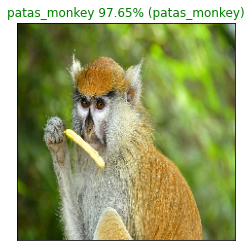

In [0]:
plot_pred(prediction_probabilities=predictions, labels=valid_labels, images=valid_images, n= 50)

Confusinon Matrix

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix - training', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.figure(figsize=(8, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


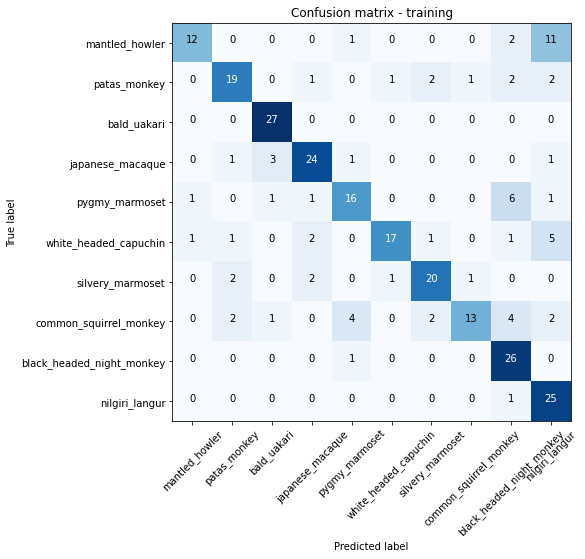

In [0]:
cm = confusion_matrix(np.array(y_valid).astype(int).argmax(axis=1), predictions.argmax(axis=1))
plot_confusion_matrix(cm, species_list, normalize=False)

Classification report

In [0]:
def show_report():
  print(classification_report(np.array(y_valid).astype(int).argmax(axis=1), predictions.argmax(axis=1)))

In [0]:
show_report()

              precision    recall  f1-score   support

           0       0.86      0.46      0.60        26
           1       0.76      0.68      0.72        28
           2       0.84      1.00      0.92        27
           3       0.80      0.80      0.80        30
           4       0.70      0.62      0.65        26
           5       0.89      0.61      0.72        28
           6       0.80      0.77      0.78        26
           7       0.87      0.46      0.60        28
           8       0.62      0.96      0.75        27
           9       0.53      0.96      0.68        26

    accuracy                           0.73       272
   macro avg       0.77      0.73      0.72       272
weighted avg       0.77      0.73      0.72       272

